
# 🏪 Store Sales Time Series Forecasting 📈

### [1. Introduction](#1-introduction)
#### [1.1. Problem Statement](#11-problem-statement)
#### 1.2. Data Description
#### 1.3. Objective
### 2. Data Exploration
#### 2.1. Importing Libraries
#### 2.2. Loading Data
#### 2.3. Data Exploration
##### 2.3.1. Univariant Analysis
##### 2.3.2. Bivariant Analysis
##### 2.3.3. Multivariant Analysis
### 3. Data Preprocessing
#### 3.1. Data Cleaning
#### 3.2. Data Transformation
#### 3.3. Data Preparation
### 4. Feature Engineering
### 5. Model Building
#### 5.1. Baseline Model
### 6. Model Evaluation


## 1. Introduction

### 1.1. Problem Statement

We have a dataset of Favorita stores located in Ecuador, we need to predict the sales of thousands of product families sold at thses stores. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building our models.

### 1.2. Data Description

> **train.csv**
>
> * The training data, comprising time series of features **store_nbr**, **family**, and **onpromotion** as well as the target **sales**.
>
> * **store_nbr** identifies the store at which the products are sold.
>
> * **family** identifies the type of product sold.
>
> * **sales** gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
>
> * **onpromotion** gives the total number of items in a product family that were being promoted at a store at a given date.


> **test.csv**
>
> * The test data, having the same features as the training data. You will predict the target **sales** for the dates in this file.
>
> * The dates in the test data are for the 15 days after the last date in the training data.


> **stores.csv**
>
> * Store metadata, including **city**, **state**, **type**, and **cluster**.
>
> * **cluster** is a grouping of similar stores.


> **oil.csv**
>
> * Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)


> **holidays_events.csv**
>
> * Holidays and Events, with metadata
>
> * NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
>
> * Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).


> **transactions.csv**
>
> * It contains **date**, **store_nbr**, **transactions**. Where **transactions** is the count of sales transactions at the store for the day.


**Additional Notes**
* Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
* A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

### 1.3. Objective

## 2. Data Exploration

### 2.1. Importing Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import datetime
import os
import warnings

sns.set_context('notebook', font_scale=1.5)
warnings.filterwarnings('ignore')

### 2.2. Loading Data

In [7]:
# Let see what data we have
print(os.listdir("../../input/store_sales_time_series_forecasting/"))

['sample_submission.csv', 'test.csv', 'train.csv', 'holidays_events.csv', 'stores.csv', 'oil.csv', 'transactions.csv', 'train_merged.csv']


In [36]:
train = pd.read_csv('../../input/store_sales_time_series_forecasting/train.csv')
test = pd.read_csv('../../input/store_sales_time_series_forecasting/test.csv')
sample_submission = pd.read_csv('../../input/store_sales_time_series_forecasting/sample_submission.csv')
holidays = pd.read_csv('../../input/store_sales_time_series_forecasting/holidays_events.csv')
oil_price = pd.read_csv('../../input/store_sales_time_series_forecasting/oil.csv')
stores = pd.read_csv('../../input/store_sales_time_series_forecasting/stores.csv')
transactions = pd.read_csv('../../input/store_sales_time_series_forecasting/transactions.csv')

### 2.3. Data Exploration

In [37]:
# Lets check the shape of these datasets
shapes = pd.DataFrame({'train': train.shape, 
                       'test': test.shape, 
                       'sample_submission': sample_submission.shape, 
                       'holidays': holidays.shape, 
                       'oil_price': oil_price.shape, 
                       'stores': stores.shape,
                       'transactions': transactions.shape}, index=['rows', 'columns'])
shapes

train   test  sample_submission  holidays  oil_price  stores  \
rows     3000888  28512              28512       350       1218      54   
columns        6      5                  2         6          2       5   

         transactions  
rows            83488  
columns             3

In [38]:
# Let's explore what's inside these datasets
train.head()

id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0

In [39]:
train.dtypes

id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

* id column is adding no information we can drop it.
* date column need to be converted to datetime format.
* family is category of the items, we will convert this column to categorical type.


In [40]:
stores.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [41]:
stores.dtypes

store_nbr     int64
city         object
state        object
type         object
cluster       int64
dtype: object

* we will combine this data with train on **store_nbr** column.
* **city**, **state**, **type** and **cluster** are categorical columns, we will convert them to categorical type.

In [42]:
transactions.head()

date  store_nbr  transactions
0  2013-01-01         25           770
1  2013-01-02          1          2111
2  2013-01-02          2          2358
3  2013-01-02          3          3487
4  2013-01-02          4          1922

In [43]:
transactions.dtypes

date            object
store_nbr        int64
transactions     int64
dtype: object

* **date**, column need to be converted to datetime format.
* we will combine this data with train on **date** and **store_nbr** columns.

In [44]:
holidays.head()

date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

In [45]:
holidays.dtypes

date           object
type           object
locale         object
locale_name    object
description    object
transferred      bool
dtype: object

* **date** column need to be converted to datetime format.
* **type**, **locale** and **locale_name** are categorical columns, we will convert them to categorical type.
* we will combine this data with train on **date** column.

In [46]:
oil_price.head()

date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20

In [47]:
oil_price.dtypes

date           object
dcoilwtico    float64
dtype: object

* **date** column need to be converted to datetime format.
* we will combine this data with train on **date** column.

Let's to required type conversion and processing in all the datasets before merging them

In [48]:
# train:
train.drop('id', axis=1, inplace=True)
train.shape

(3000888, 5)

In [49]:
# train:
train['date'] = pd.to_datetime(train['date'])

# transactions:
transactions['date'] = pd.to_datetime(transactions['date'])

# holidays:
holidays['date'] = pd.to_datetime(holidays['date'])

#oil_price:
oil_price['date'] = pd.to_datetime(oil_price['date'])

In [50]:
# Let's check the column of train on which we will do merging
print("Checking for null values")
print("Date:", train.date.isna().sum())
print("Store Number:", train.store_nbr.isna().sum())

Checking for null values
Date: 0
Store Number: 0


In [51]:
train.shape

(3000888, 5)

In [52]:
# Nice, we dont have any missing value in the key columns of train, Let's merge these datasets to get a single dataset named 'train_merged'
train_merged = train.merge(stores, how="left", on="store_nbr")
train_merged.head()

date  store_nbr      family  sales  onpromotion   city      state  \
0 2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
1 2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha   
2 2013-01-01          1      BEAUTY    0.0            0  Quito  Pichincha   
3 2013-01-01          1   BEVERAGES    0.0            0  Quito  Pichincha   
4 2013-01-01          1       BOOKS    0.0            0  Quito  Pichincha   

  type  cluster  
0    D       13  
1    D       13  
2    D       13  
3    D       13  
4    D       13

In [53]:
train_merged.shape

(3000888, 9)

In [54]:
train_merged = train_merged.merge(transactions, how="left", on=["date", "store_nbr"])
train_merged.head()

date  store_nbr      family  sales  onpromotion   city      state  \
0 2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
1 2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha   
2 2013-01-01          1      BEAUTY    0.0            0  Quito  Pichincha   
3 2013-01-01          1   BEVERAGES    0.0            0  Quito  Pichincha   
4 2013-01-01          1       BOOKS    0.0            0  Quito  Pichincha   

  type  cluster  transactions  
0    D       13           NaN  
1    D       13           NaN  
2    D       13           NaN  
3    D       13           NaN  
4    D       13           NaN

In [55]:
train_merged.shape

(3000888, 10)

In [56]:
# Let's drop the transferred holidays and type Work Day before merging
holidays = holidays[(holidays.transferred == False) & (holidays.type != 'Work Day')]

In [57]:
# Separating Local, Regional and National holidays
df_local = holidays[holidays.locale == 'Local'][['date', 'locale_name']].drop_duplicates()
df_reg = holidays[holidays.locale == 'Regional'][['date', 'locale_name']].drop_duplicates()
df_national = holidays[holidays.locale == 'National'][['date']].drop_duplicates()

# Merging holidays to train dataset
train_merged = train_merged.merge(holidays.loc[df_local.index], how='left', left_on=['date', 'city'], right_on=['date', 'locale_name'])
# train_merged = train_merged.merge(holidays.loc[df_national.index], how='left', left_on=['date'], right_on=['date'])

In [58]:
train_merged.head(2)

date  store_nbr      family  sales  onpromotion   city      state  \
0 2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
1 2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha   

  type_x  cluster  transactions type_y locale locale_name description  \
0      D       13           NaN    NaN    NaN         NaN         NaN   
1      D       13           NaN    NaN    NaN         NaN         NaN   

  transferred  
0         NaN  
1         NaN

In [59]:
train_merged.shape

(3000888, 15)

In [60]:
train_merged = train_merged.rename(columns={'type_x':'product_type', 'type_y': 'holiday_type'})

In [61]:
train_merged = train_merged.merge(holidays.loc[df_reg.index], how='left', left_on=['date', 'state'], right_on=['date', 'locale_name'])
train_merged.head(2)

date  store_nbr      family  sales  onpromotion   city      state  \
0 2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
1 2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha   

  product_type  cluster  transactions holiday_type locale_x locale_name_x  \
0            D       13           NaN          NaN      NaN           NaN   
1            D       13           NaN          NaN      NaN           NaN   

  description_x transferred_x type locale_y locale_name_y description_y  \
0           NaN           NaN  NaN      NaN           NaN           NaN   
1           NaN           NaN  NaN      NaN           NaN           NaN   

  transferred_y  
0           NaN  
1           NaN

In [79]:
# train_merged[(train_merged.type.isna() == False) & ((train_merged.holiday_type.isna() == False))]
# train_merged.dtypes
# train_merged['holiday_type'].value_counts()
# train_merged['type'].value_counts()
df_t2 = pd.DataFrame()
df_t2['holiday_type'] = train_merged.holiday_type.combine(train_merged.type, lambda x, y: np.nan if pd.isnull(x) and pd.isnull(y) else x if pd.isnull(y) else y)
df_t2['locale'] = train_merged.locale_name_x.combine(train_merged.locale_name_y, lambda x, y: np.nan if pd.isnull(x) and pd.isnull(y) else x if pd.isnull(y) else y)
df_t2['locale_name'] = train_merged.locale_name_x.combine(train_merged.locale_name_y, lambda x, y: np.nan if pd.isnull(x) and pd.isnull(y) else x if pd.isnull(y) else y)
df_t2['description'] = train_merged.description_x.combine(train_merged.description_y, lambda x, y: np.nan if pd.isnull(x) and pd.isnull(y) else x if pd.isnull(y) else y)
df_t2['transferred'] = train_merged.transferred_x.combine(train_merged.transferred_y, lambda x, y: np.nan if pd.isnull(x) and pd.isnull(y) else x if pd.isnull(y) else y)

train_merged = train_merged.drop(columns=["holiday_type",	"locale_x",	"locale_name_x",	"description_x",	"transferred_x",	"type",	"locale_y",	"locale_name_y",	"description_y",	"transferred_y"])


TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [81]:
train_merged = pd.concat([train_merged, df_t2], axis=1)

In [82]:
train_merged.head()

date  store_nbr      family  sales  onpromotion   city      state  \
0 2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
1 2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha   
2 2013-01-01          1      BEAUTY    0.0            0  Quito  Pichincha   
3 2013-01-01          1   BEVERAGES    0.0            0  Quito  Pichincha   
4 2013-01-01          1       BOOKS    0.0            0  Quito  Pichincha   

  product_type  cluster  transactions holiday_type locale locale_name  \
0            D       13           NaN          NaN    NaN         NaN   
1            D       13           NaN          NaN    NaN         NaN   
2            D       13           NaN          NaN    NaN         NaN   
3            D       13           NaN          NaN    NaN         NaN   
4            D       13           NaN          NaN    NaN         NaN   

  description transferred  
0         NaN         NaN  
1         NaN         NaN  
2         NaN         NaN  
3         NaN         NaN  
4         NaN         NaN

In [83]:
train_merged.shape

(3000888, 15)

In [84]:
train_merged = train_merged.merge(oil_price, how="left", on="date")
# train_merged.head()

Now we have a sinlge combined dataset, let's do some analysis on it.

In [85]:
# summary statistics of numeric data
df_num = train_merged.select_dtypes(include=np.number)
summary_num = pd.DataFrame({'missing_val': df_num.isna().sum(), 
                        'unique_val': df_num.nunique(), 
                        'min': df_num.min(), 
                        'max': df_num.max(), 
                        'mean': df_num.mean(), 
                        'std': df_num.std(), })
summary_num

missing_val  unique_val    min        max         mean  \
store_nbr               0          54   1.00      54.00    27.500000   
sales                   0      379610   0.00  124717.00   357.775749   
onpromotion             0         362   0.00     741.00     2.602770   
cluster                 0          17   1.00      17.00     8.481481   
transactions       245784        4993   5.00    8359.00  1694.602158   
dcoilwtico         928422         994  26.19     110.62    67.925589   

                      std  
store_nbr       15.585787  
sales         1101.997721  
onpromotion     12.218882  
cluster          4.649735  
transactions   963.281049  
dcoilwtico      25.666331

* We have **54** unique stores in the dataset.
* There are missing values in **transactions** and **dcoilwtico** columns, we need to treat them.

In [86]:
# summary statistics of non numeric data
df_non_num = train_merged.select_dtypes(['category', 'object', 'datetime64'])
summary_non_num = pd.DataFrame({'missing_val': df_non_num.isna().sum(),
                                'unique_val': df_non_num.nunique(),
                                'mode': df_non_num.mode().iloc[0],})
summary_non_num

missing_val  unique_val                 mode
date                    0        1684  2013-01-01 00:00:00
family                  0          33           AUTOMOTIVE
city                    0          22                Quito
state                   0          16            Pichincha
product_type            0           5                    D
holiday_type      2987985           3              Holiday
locale            2987985          23                Quito
locale_name       2987985          23                Quito
description       2987985          29   Fundacion de Quito
transferred       2987985           1                False

* There are missing values in **holiday_type**, **locale**, **locale_name**, **description** and **transferred** columns, we need to treat them.

#### 2.3.1. Univariant Analysis

Let's start with the **date** variable.

In [87]:
df_non_num.date.min(), df_non_num.date.max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

* We have data from Jan 2013 to Aug 2017.

In [88]:
df_non_num.date.max() - df_non_num.date.min()

Timedelta('1687 days 00:00:00')

In [89]:
df_non_num.date.nunique()

1684

* Only few dates are imssing from the time span.

Let's see **family** variable.

In [90]:
df_non_num.family.value_counts().nunique()

1

* All product family have similar frequency in the dataset.


Let's see **city** and **state** variable.

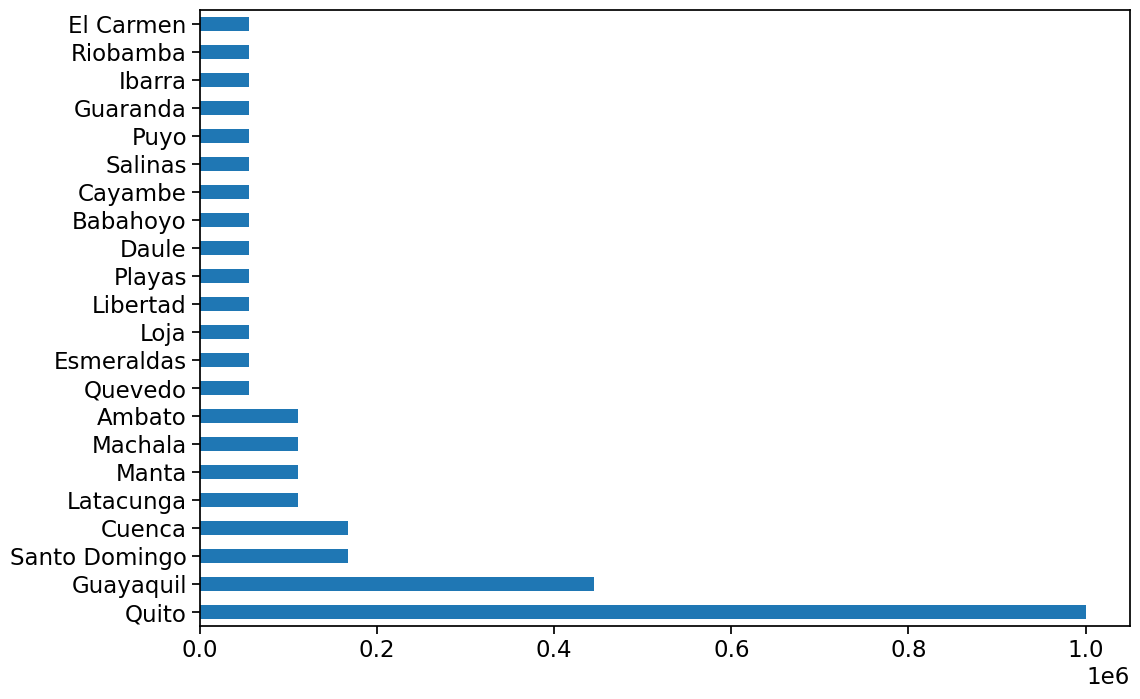

In [91]:
plt.figure(figsize=(12,8))
df_non_num.city.value_counts().plot(kind='barh')
plt.show()

* Stores in city **Quito** have highest frequency in the dataset followed by **Guayaquil**.

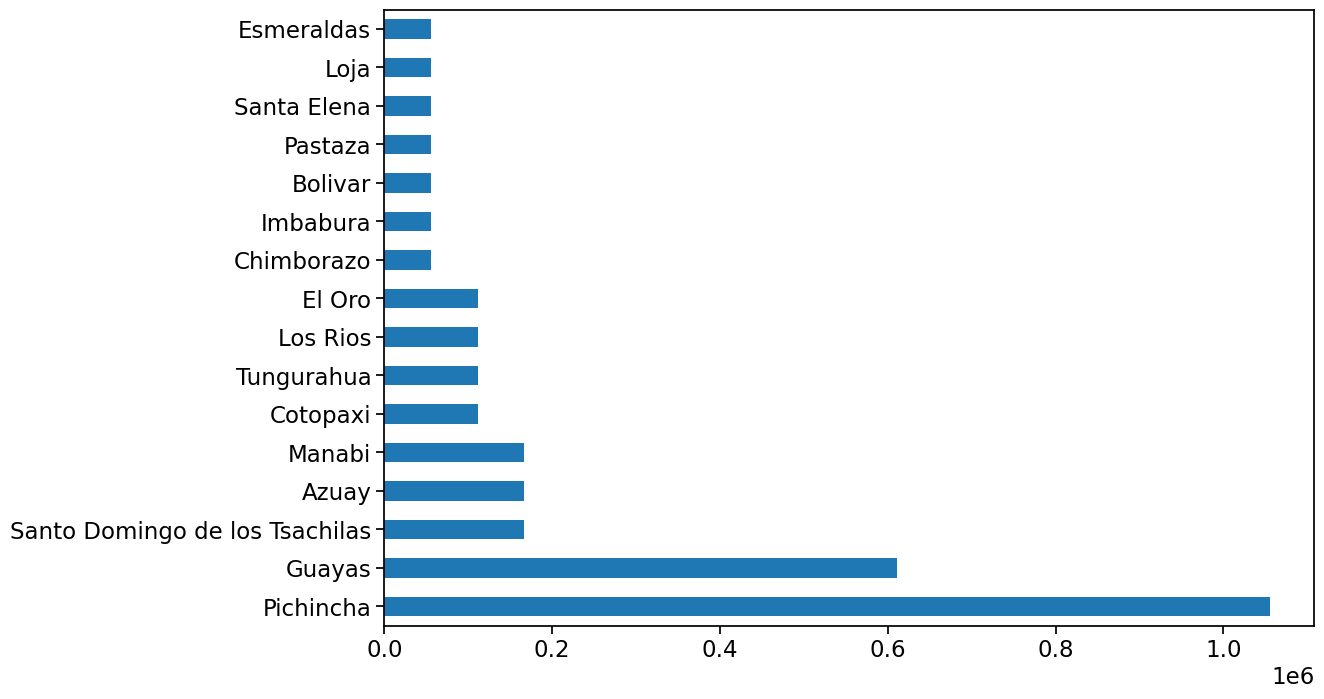

In [92]:
plt.figure(figsize=(12,8))
df_non_num.state.value_counts().plot(kind='barh')
plt.show()

* As expected, frequency of state are also similar to city.

Let's see **product_type** variable.

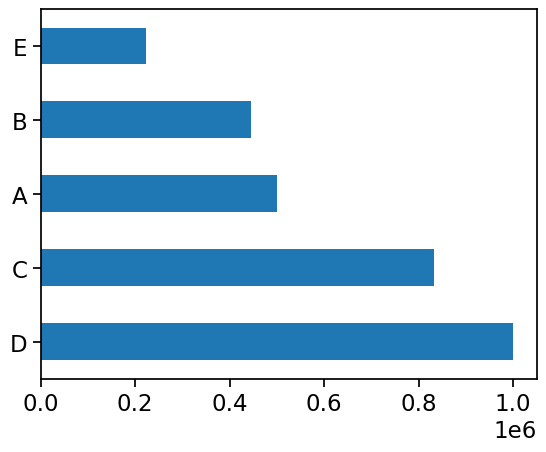

In [93]:
# plt.figure(figsize=(12,8))
df_non_num.product_type.value_counts().plot(kind='barh')
plt.show()

Let's see **cluster** variable.

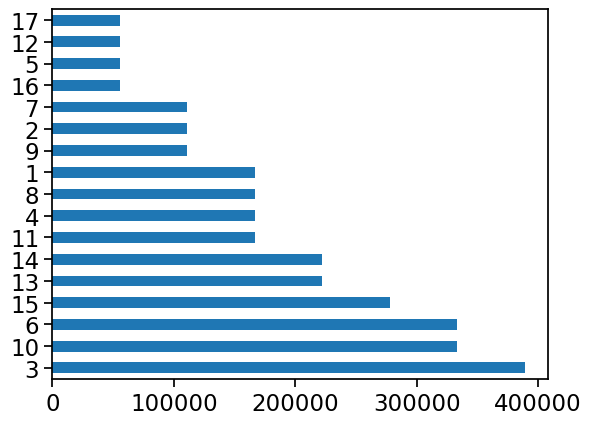

In [96]:
df_num.cluster.value_counts().plot(kind='barh')
plt.show()

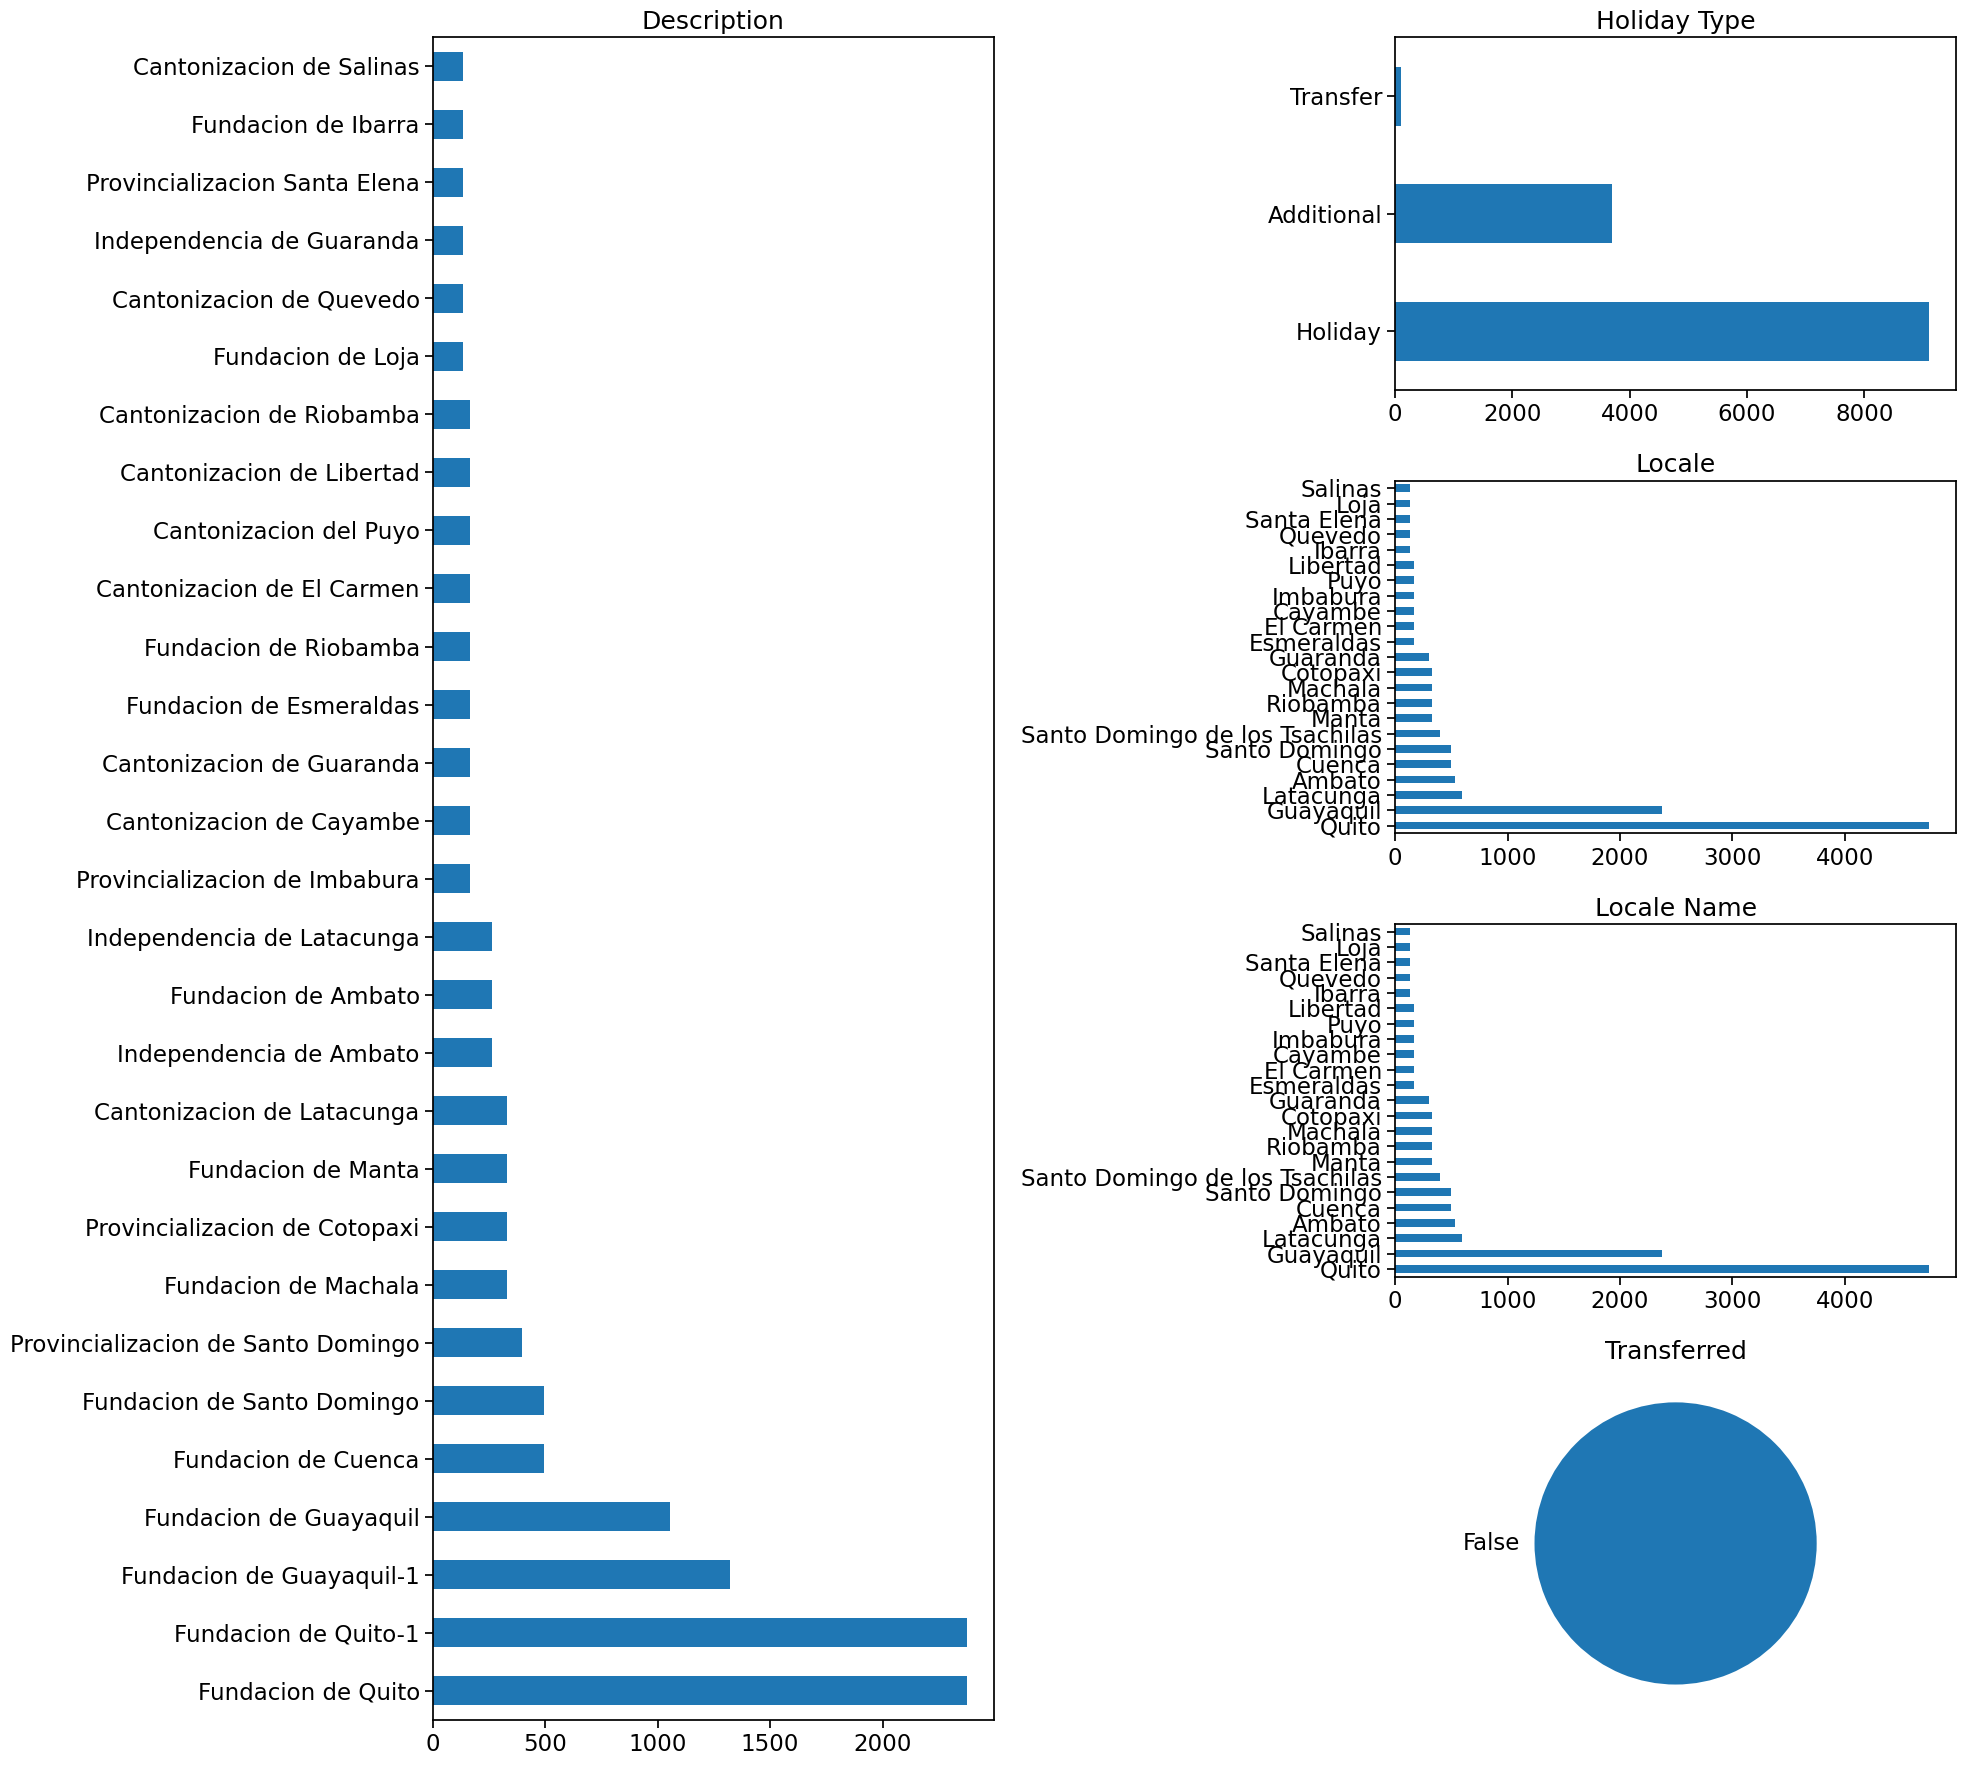

In [97]:
fig = plt.figure(layout="constrained", figsize=(20,18))
ax1 = plt.subplot2grid((4,2), (0,0), rowspan=4)
ax2 = plt.subplot2grid((4,2), (0,1))
ax3 = plt.subplot2grid((4,2), (1,1))
ax4 = plt.subplot2grid((4,2), (2,1))
ax5 = plt.subplot2grid((4,2), (3,1))

df_non_num.description.value_counts().plot(kind='barh', ax=ax1, title="Description")
df_non_num.holiday_type.value_counts().plot(kind='barh', ax=ax2, title="Holiday Type")
df_non_num.locale.value_counts().plot(kind='barh', ax=ax3, title="Locale")
df_non_num.locale_name.value_counts().plot(kind='barh', ax=ax4, title="Locale Name")
df_non_num.transferred.value_counts().plot(kind='pie', ax=ax5, title="Transferred", ylabel='')

plt.tight_layout()
plt.show()

* **transferred** column is not adding any information, we can drop it.

In [98]:
train_merged.drop(columns=['transferred'], inplace=True)

Let's see the distributions of numerical variables.

* **sales:**
* **store_nbr:**
* **onpromotion:**
* **transactions:**
* **dcoilwtico:**

<Figure size 800x800 with 0 Axes>

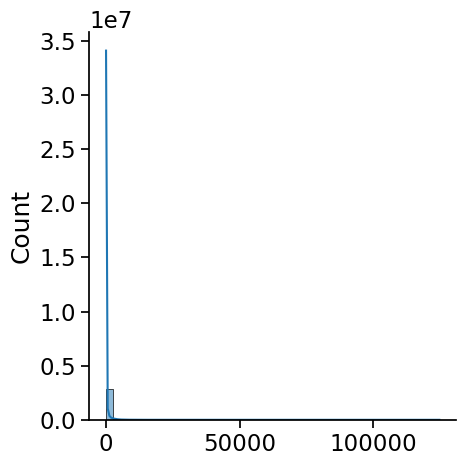

In [99]:
plt.figure(figsize=(8,8))
sns.displot((df_num.sales.values), bins=50, kde=True)
plt.show()

* A large proportion of the **sales** is 0, let's plot the log distribution.

<Figure size 800x800 with 0 Axes>

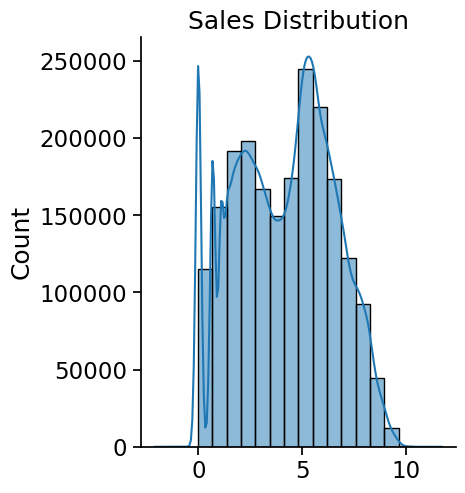

In [100]:
plt.figure(figsize=(8,8))
sns.displot(np.log(df_num.sales.values), bins=20, kde=True)
plt.title("Sales Distribution")
plt.show()

* **Stores:**

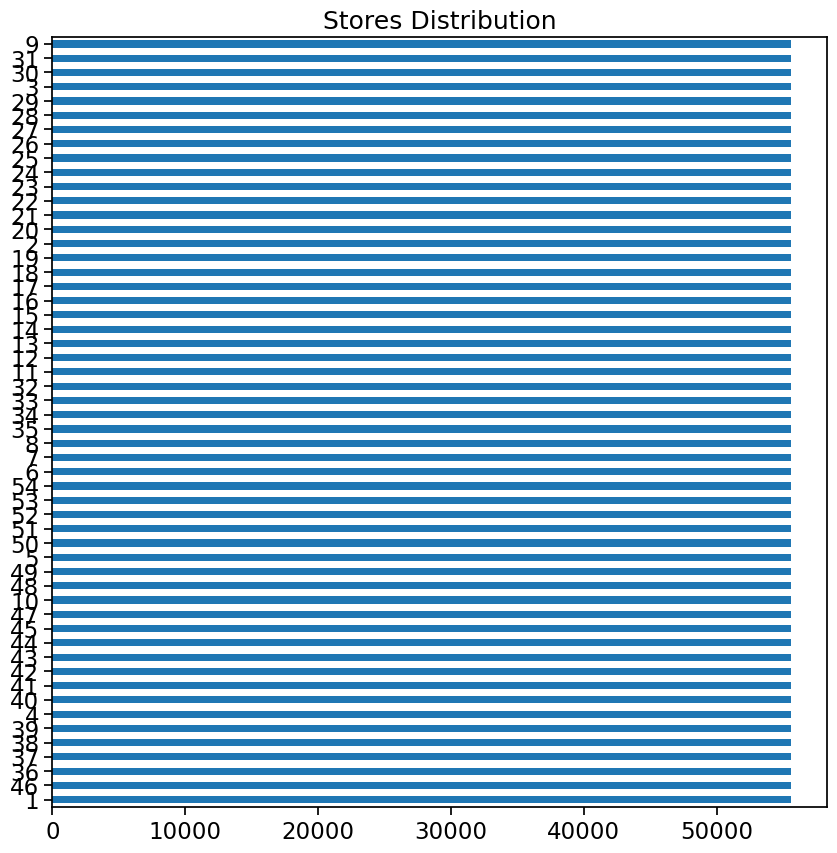

In [101]:
plt.figure(figsize=(10,10))
df_num.store_nbr.value_counts().plot(kind='barh')
plt.title("Stores Distribution")
plt.show()

* All stores have same frequency in data.


* **onpromotion:**

<Figure size 1000x800 with 0 Axes>

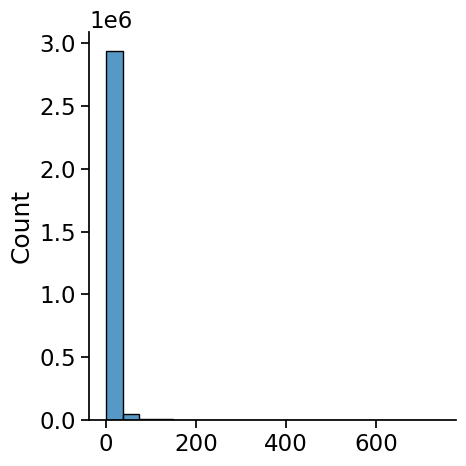

In [102]:
plt.figure(figsize=(10,8))
sns.displot((df_num.onpromotion.values), bins=20)
plt.show()

Most of the values are 0n let's plot log

<Figure size 1000x800 with 0 Axes>

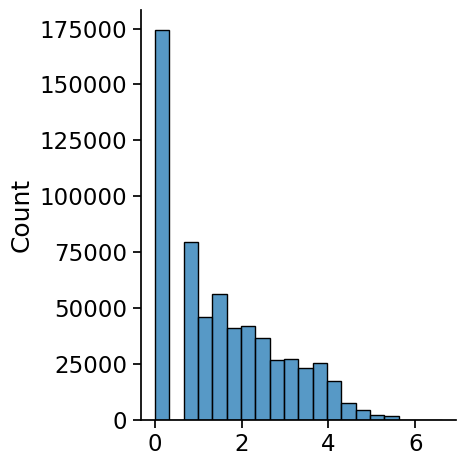

In [103]:
plt.figure(figsize=(10,8))
sns.displot(np.log(df_num.onpromotion.values), bins=20)
plt.show()

* **transactions:**

<Figure size 1000x800 with 0 Axes>

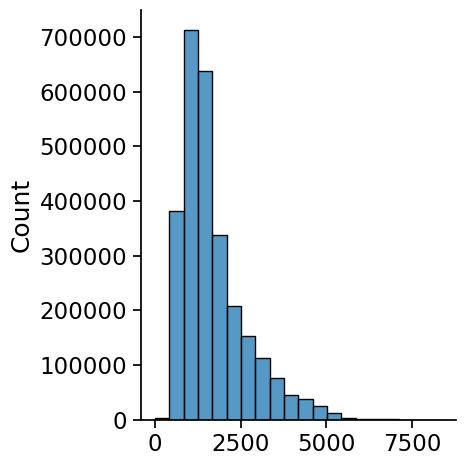

In [104]:
plt.figure(figsize=(10,8))
sns.displot((df_num.transactions.values), bins=20)
plt.show()

* **dcoilwtico:**

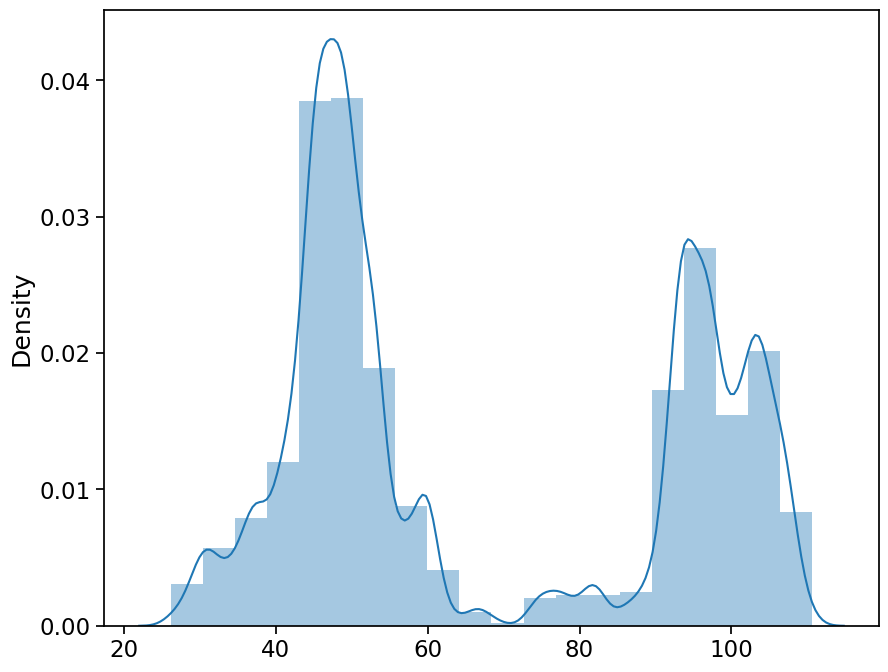

In [105]:
plt.figure(figsize=(10,8))
sns.distplot((df_num.dcoilwtico.values), bins=20)
plt.show()

#### 2.3.2. Multivariate Analysis

* How **sales** look for different product **family**?

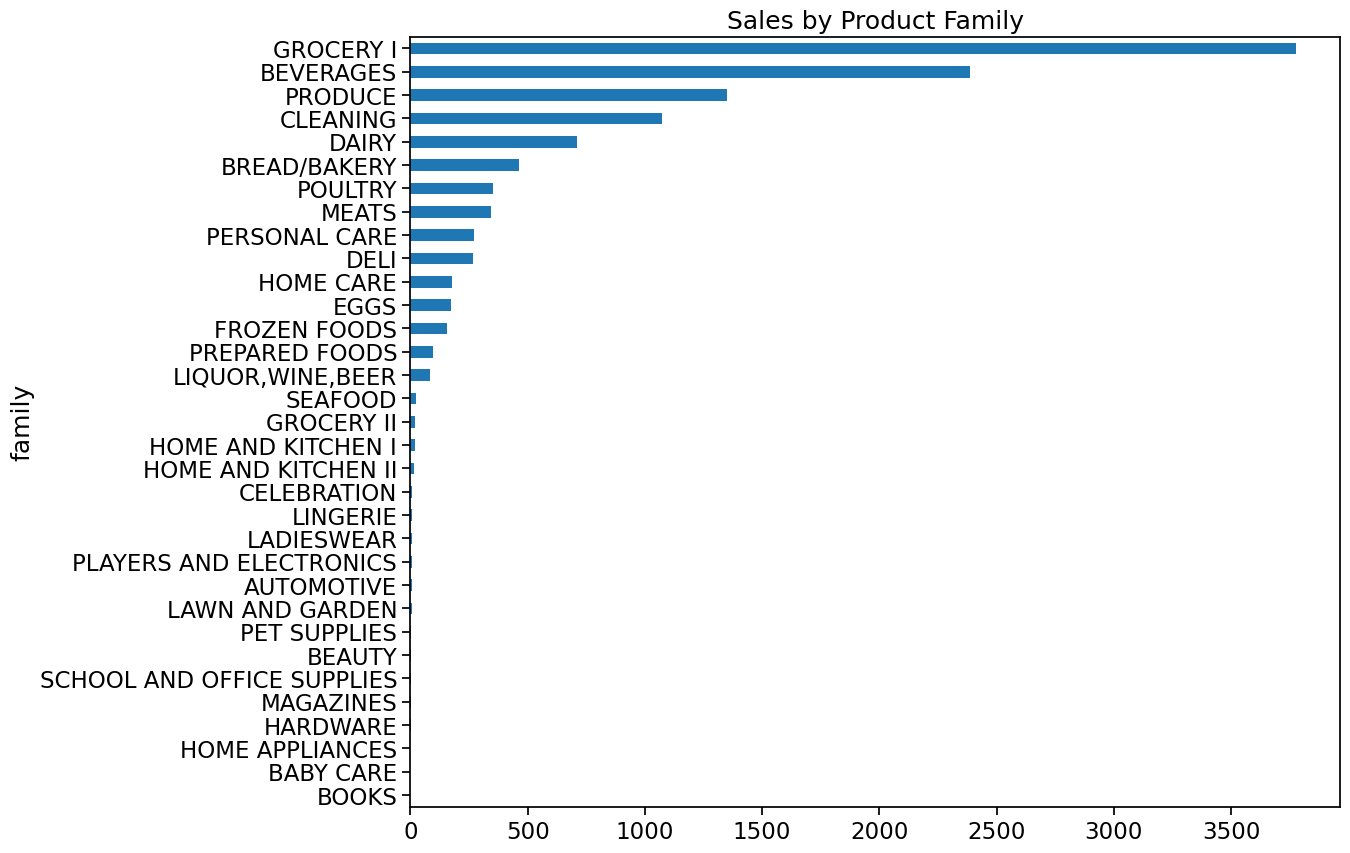

In [106]:
plt.figure(figsize=(12,10))
train_merged.groupby('family')['sales'].mean().sort_values().plot(kind='barh', title="Sales by Product Family")
plt.show()

* **GROCERY I** is highest selling product family followed by **BEVERAGES**.

* Let's see how **sales** look for different **city** and **state**.

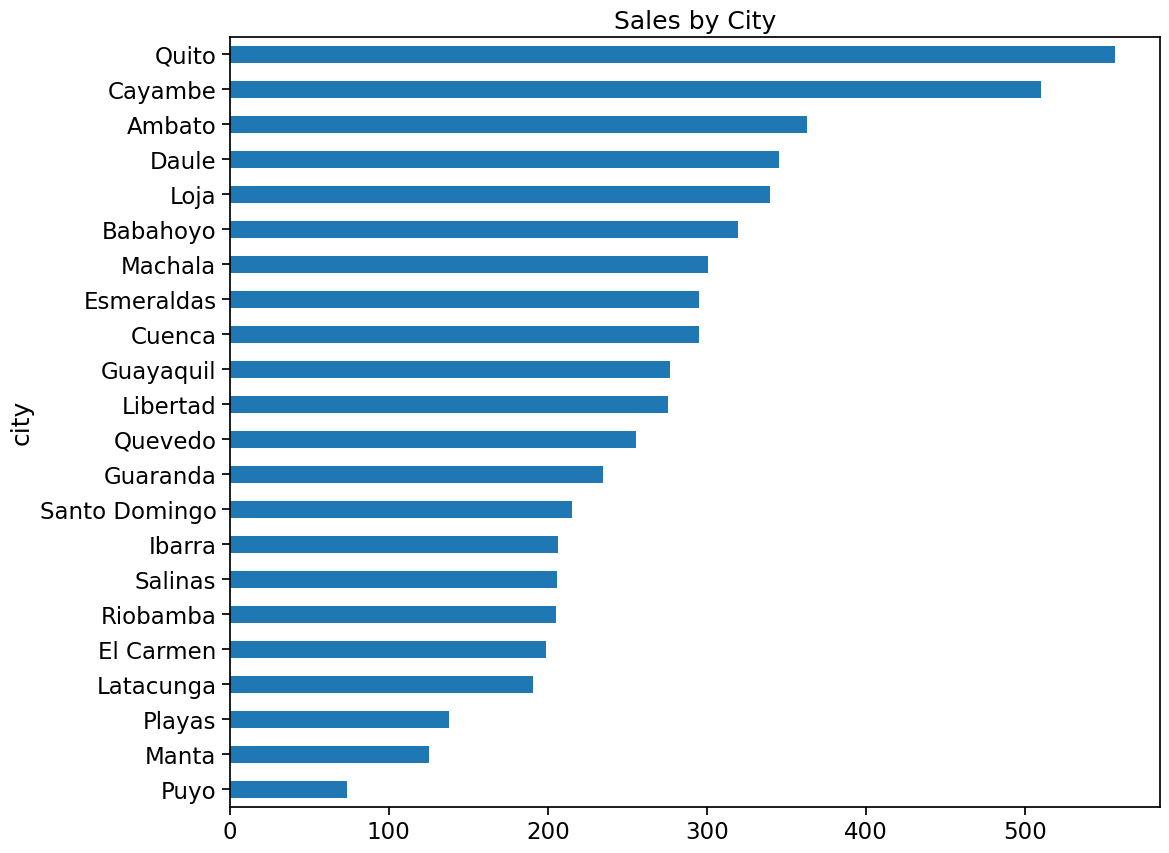

In [107]:
plt.figure(figsize=(12,10))
train_merged.groupby('city')['sales'].mean().sort_values().plot(kind='barh', title="Sales by City")
plt.show()

* **Quito** and **Cayas** have highest sales.

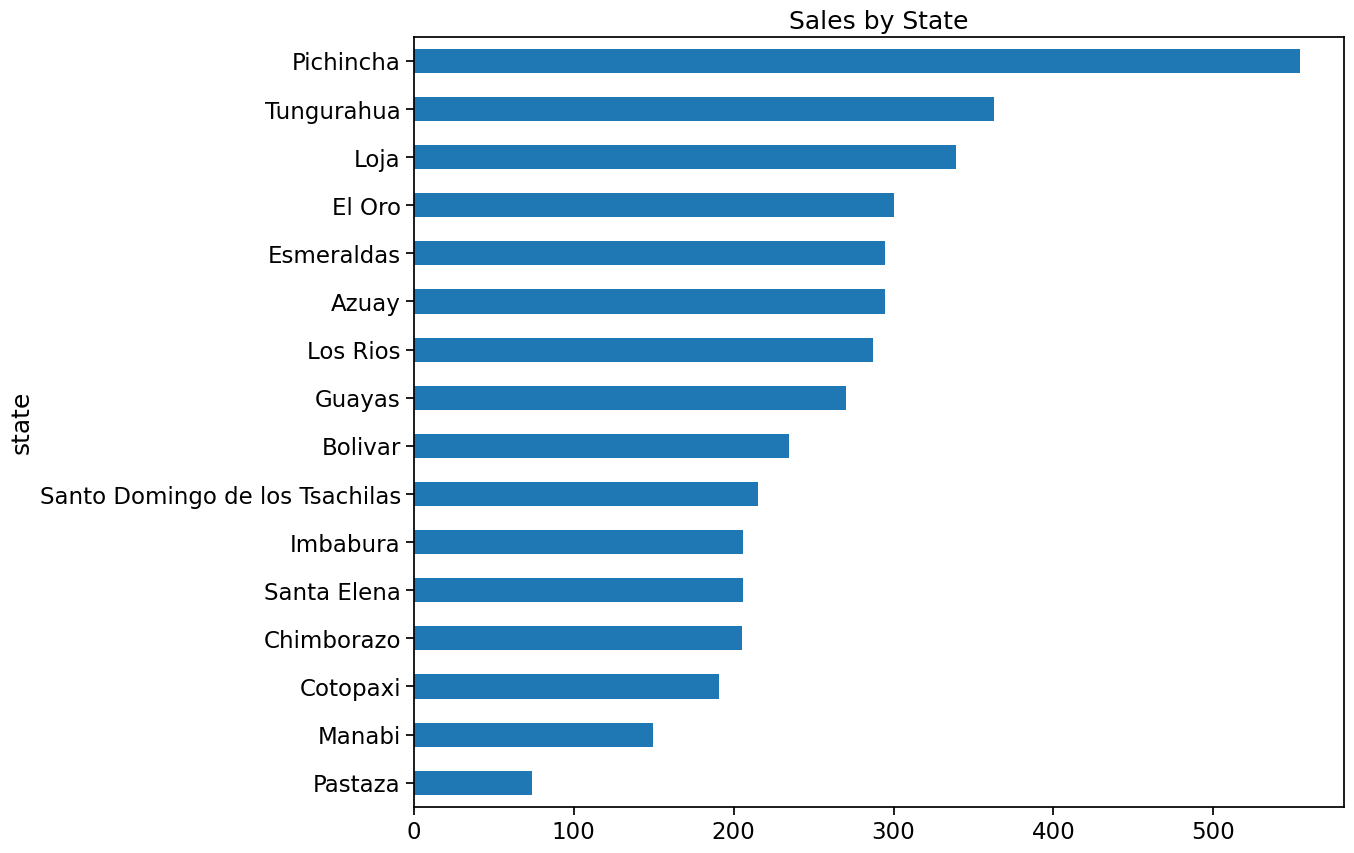

In [108]:
plt.figure(figsize=(12,10))
train_merged.groupby('state')['sales'].mean().sort_values().plot(kind='barh', title="Sales by State")
plt.show()

* **Pichincha** has highest sales, followed bu **Tungurahua** and **Loja**.

* Let's see how **sales** look for different **product_type**.

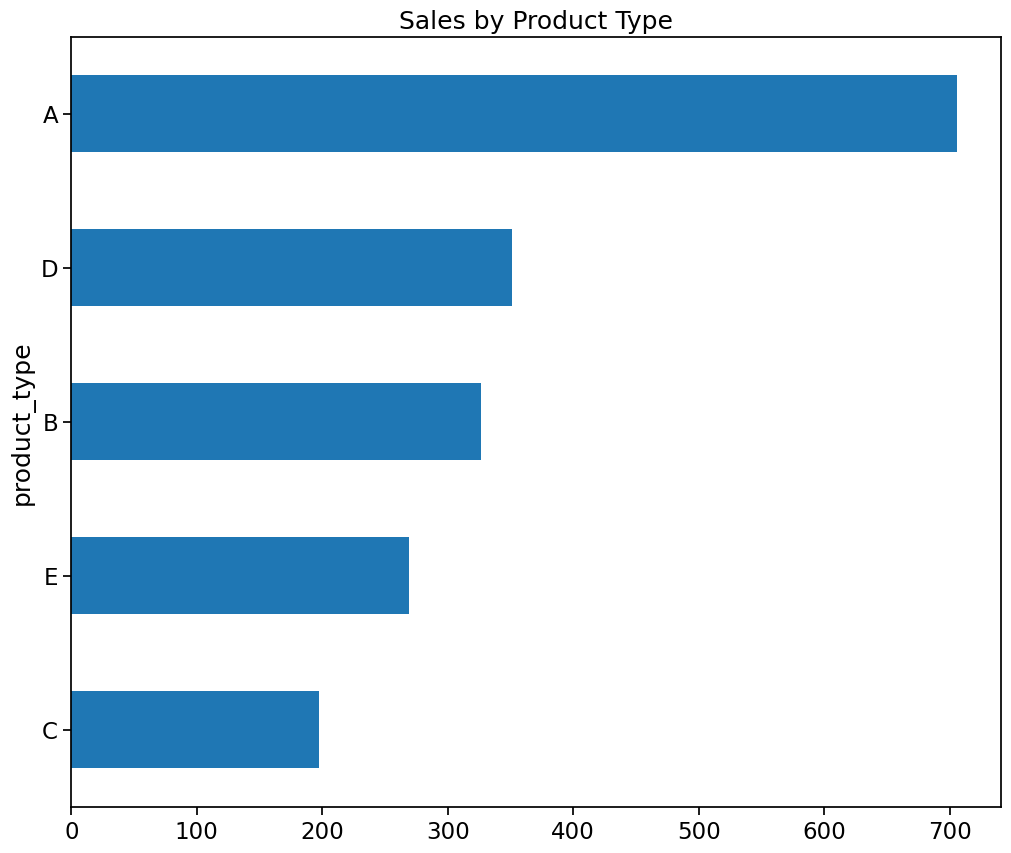

In [109]:
plt.figure(figsize=(12,10))
train_merged.groupby('product_type')['sales'].mean().sort_values().plot(kind='barh', title="Sales by Product Type")
plt.show()

* Produc type **A** has highest sales.

* Let's see how **sales** look for different **cluster**.

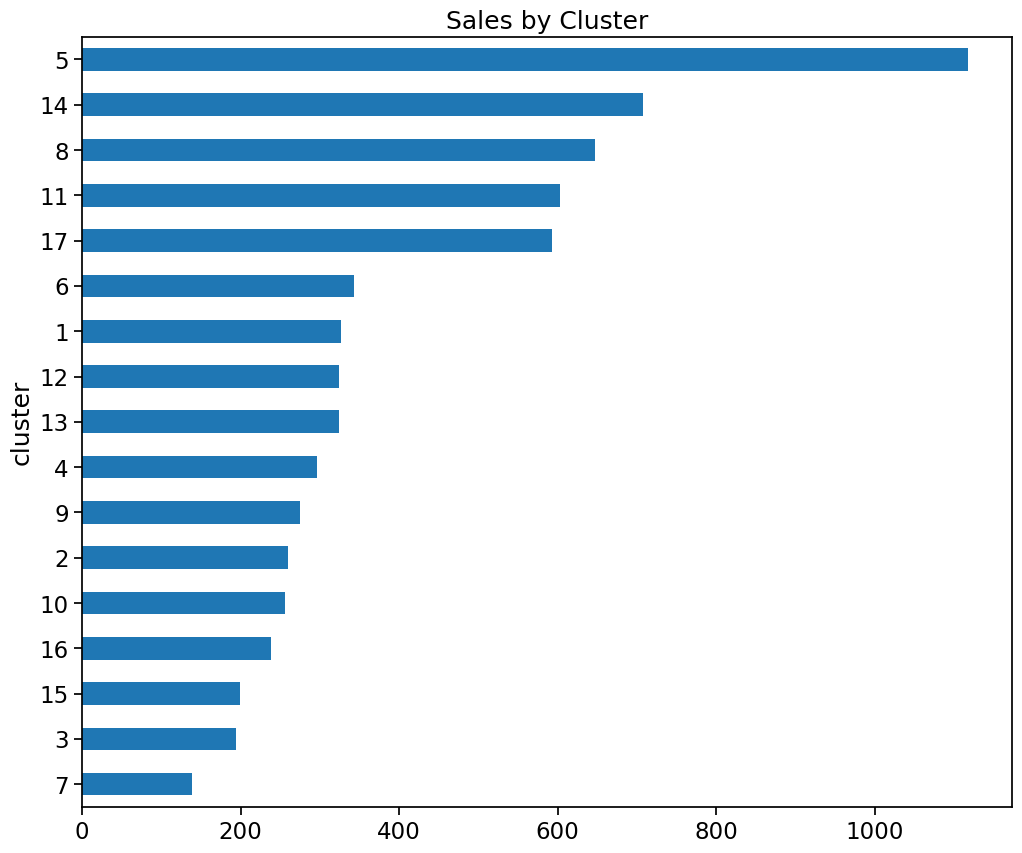

In [110]:
plt.figure(figsize=(12,10))
train_merged.groupby('cluster')['sales'].mean().sort_values().plot(kind='barh', title="Sales by Cluster")
plt.show()

* Let's see how **sales** look over time.

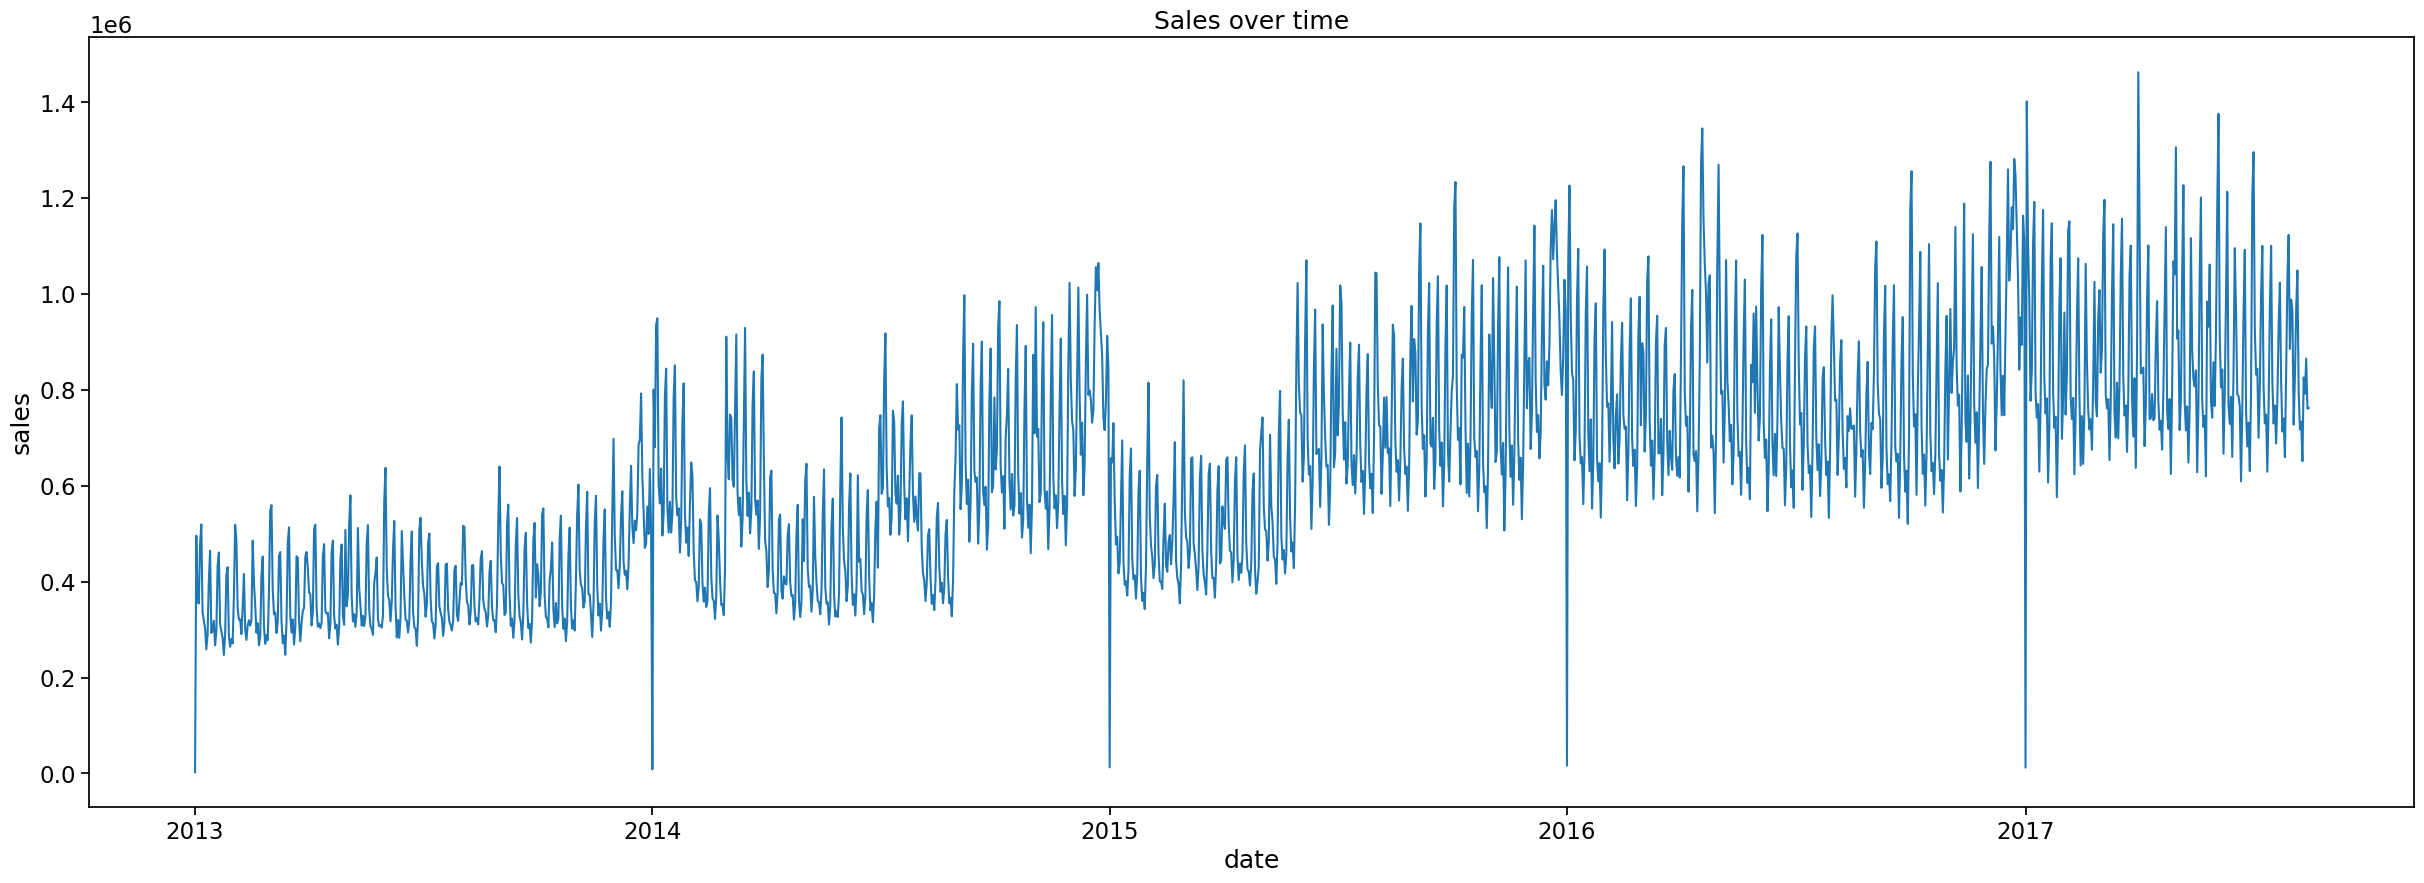

In [111]:
# Sum of units sold daily
df_daily_sales = train_merged.groupby(['date'])['sales'].sum()

plt.figure(figsize=(30,10))
sns.lineplot(x=df_daily_sales.index, y=df_daily_sales)
plt.title("Sales over time")
plt.show()

* We can see a clear jump in sales near the end of every year, this shows seasonality in the data.
* Sales are increasing ove time

* Let's see the average **sales** by **family** over time.

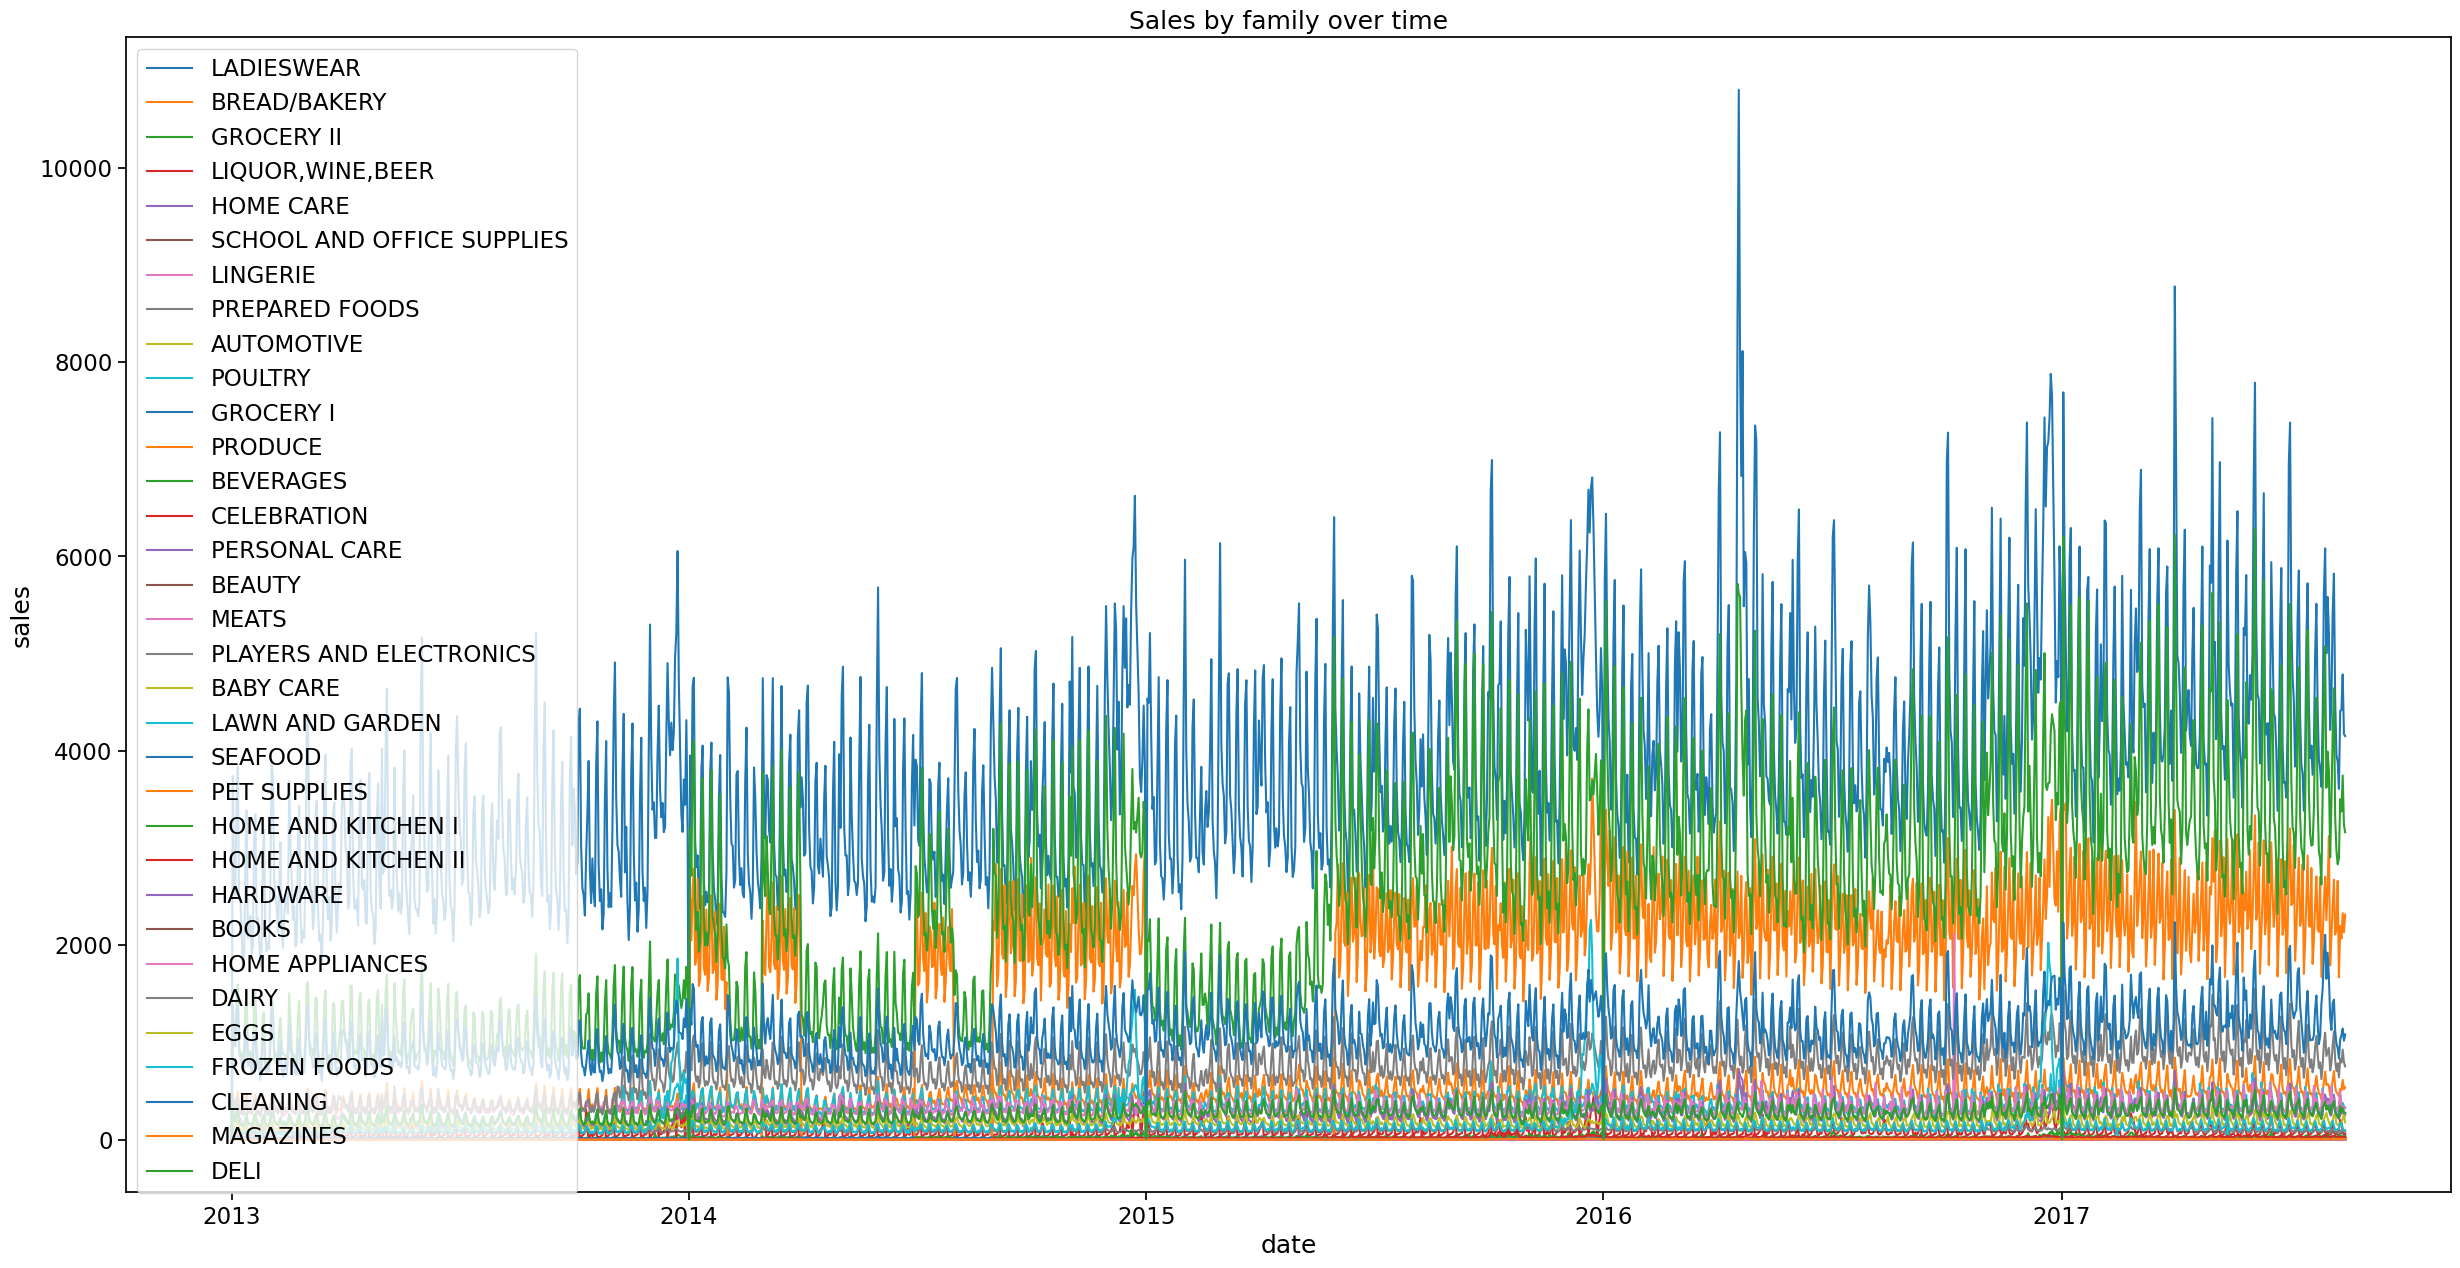

In [112]:
plt.figure(figsize=(30,15))
for f in set(train_merged.family.values):
    df_sales_by_f = train_merged[train_merged.family == f].groupby(['date'])['sales'].mean()
    sns.lineplot(x=df_sales_by_f.index, y=df_sales_by_f, label=f)

plt.legend(loc='upper left')
plt.title("Sales by family over time")
plt.show()


* We can clearly see that there are few product families which have very high sales compared to a large number of product families which have very low sales.

* Let's see the average **sales** by **product_type**

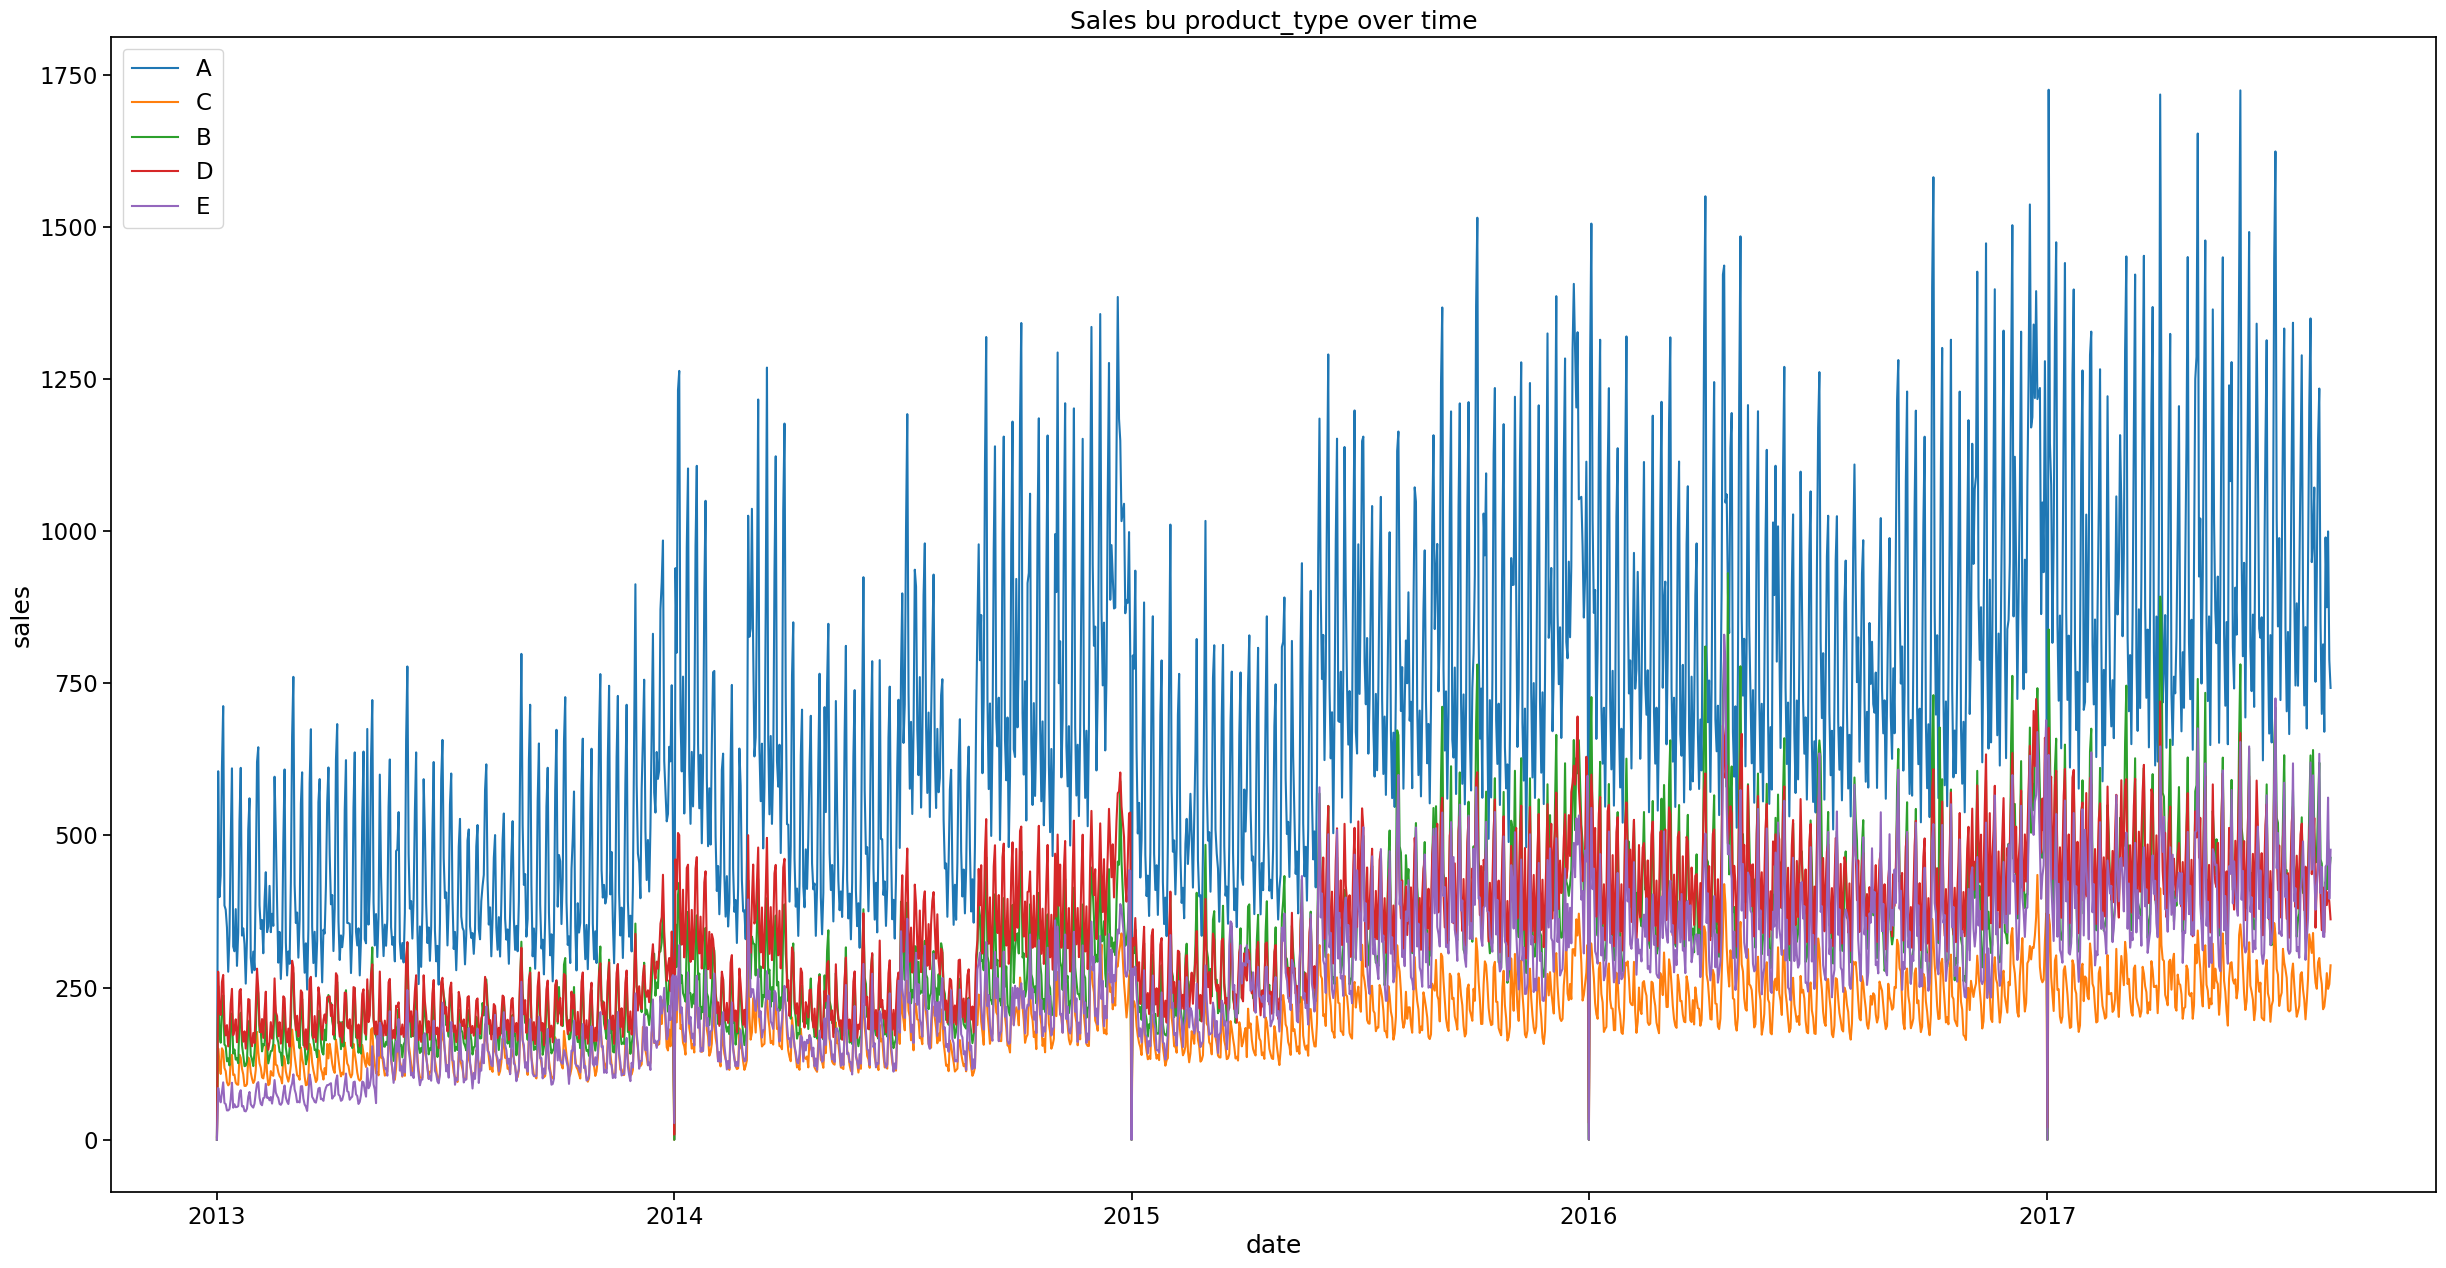

In [113]:
plt.figure(figsize=(30,15))
for p in set(train_merged.product_type.values):
    df_sales_by_p = train_merged[train_merged.product_type == p].groupby(['date'])['sales'].mean()
    sns.lineplot(x=df_sales_by_p.index, y=df_sales_by_p, label=p)

plt.legend(loc='upper left')
plt.title("Sales bu product_type over time")
plt.show()


* We can see that product type **A** has highest sales over time.

Let's see how the sales affected by the holidays.

In [115]:
train_merged.holiday_type.value_counts()

Holiday       9108
Additional    3696
Transfer        99
Name: holiday_type, dtype: int64

In [116]:
# Let's create a column to indicate if there was a holiday on the date
train_merged['is_holiday'] = train_merged.holiday_type.apply(lambda x: 99999 if x in ('Holiday', 'Additional', 'Transfer') else 0)
train_merged.is_holiday.fillna(0, inplace=True)
train_merged.is_holiday.value_counts()

0        2987985
99999      12903
Name: is_holiday, dtype: int64

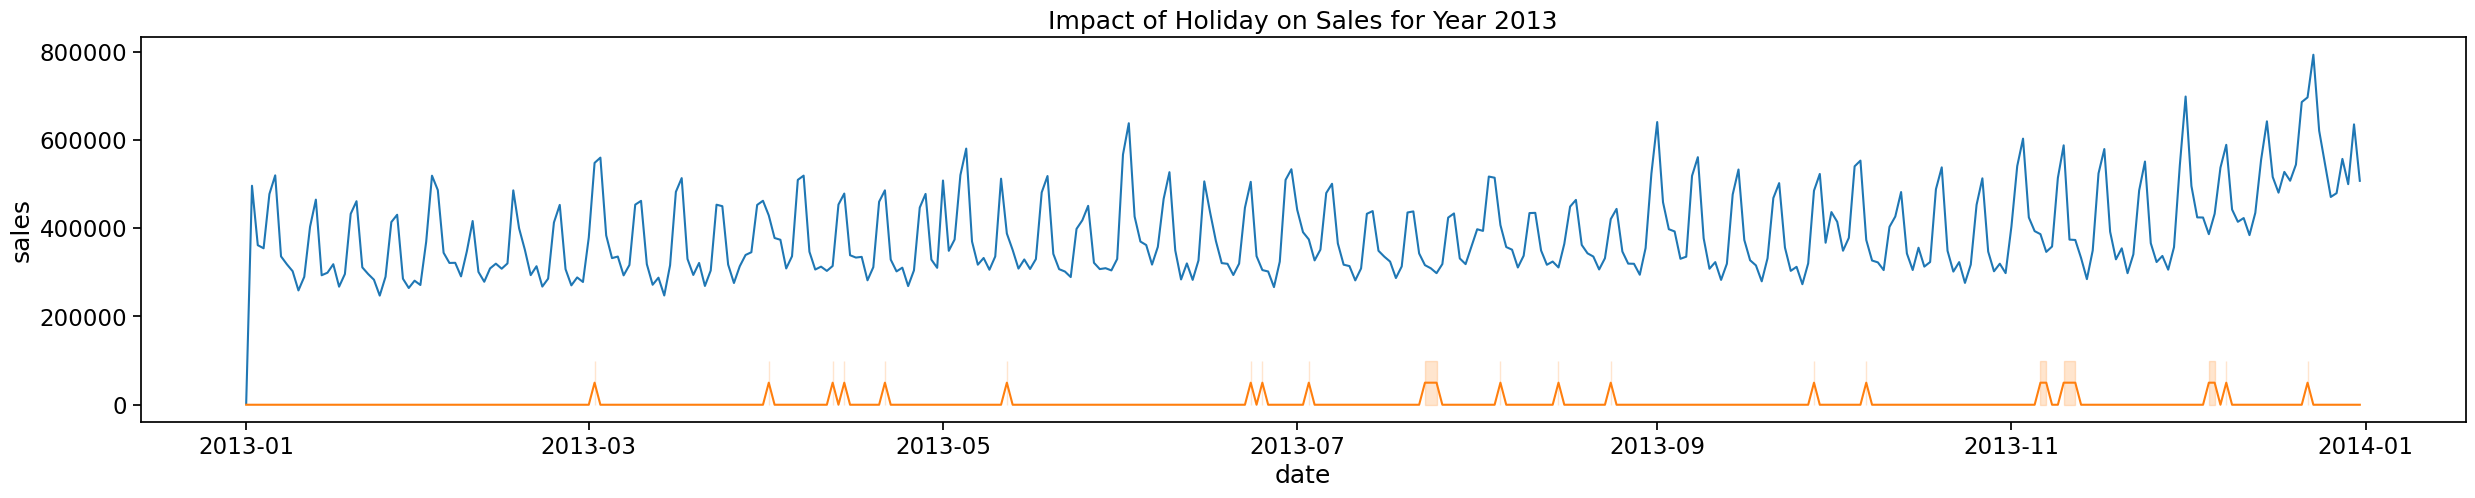

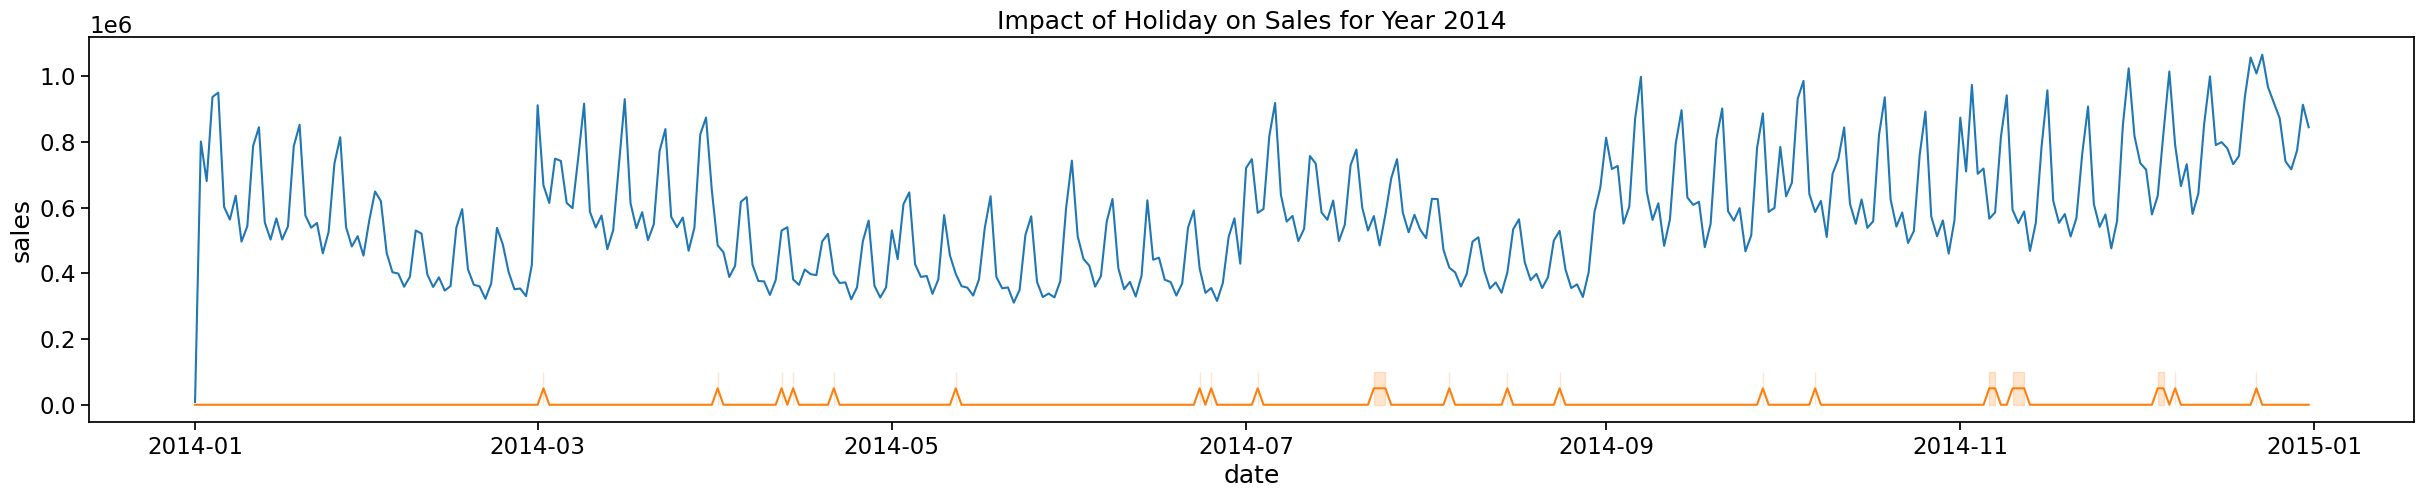

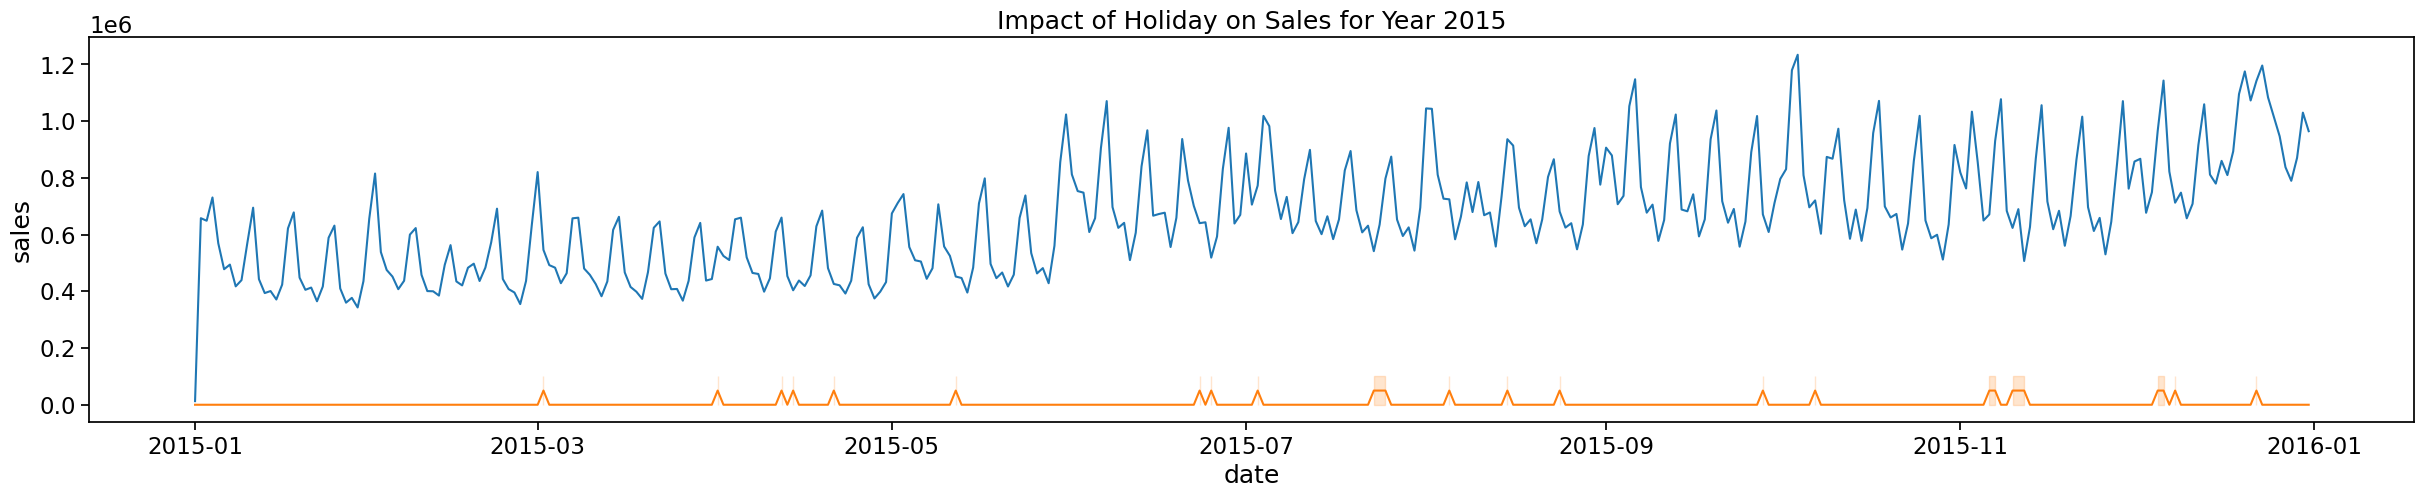

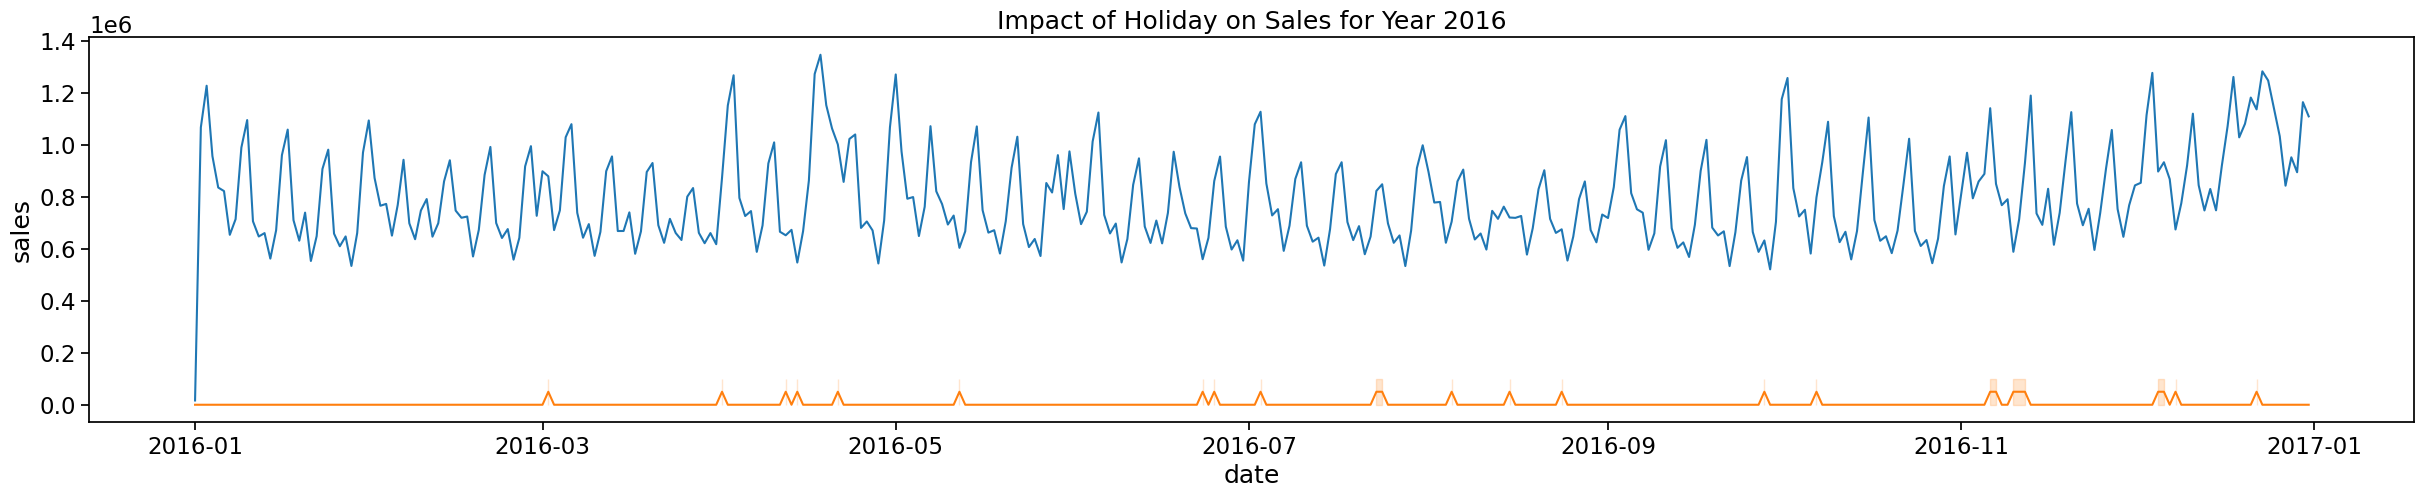

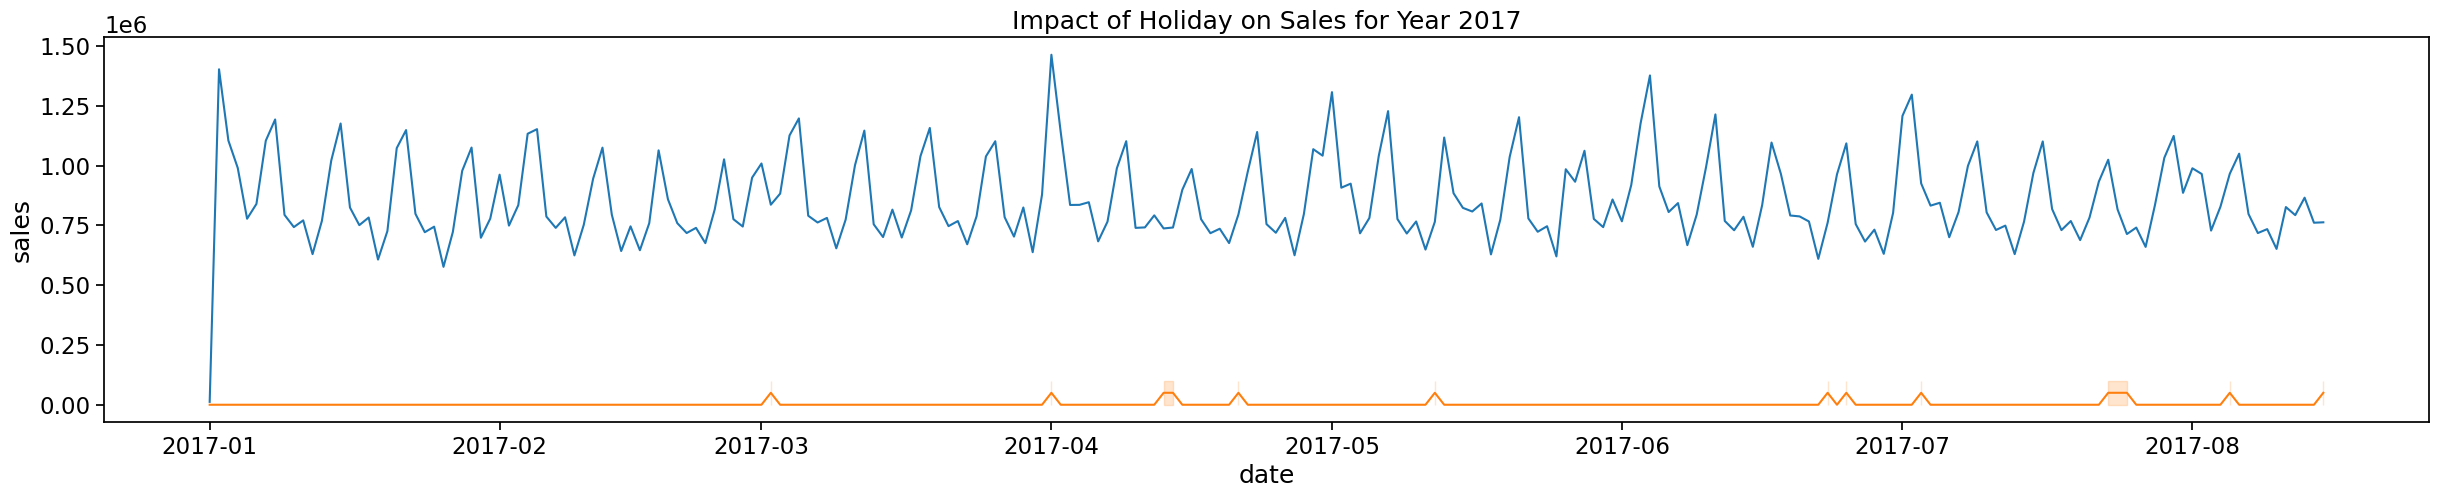

In [117]:
# Ploting impact of holidays on sales pover time
for year in train_merged.date.dt.year.unique():
    plt.figure(figsize=(30,5))
    df_daily_sales = train_merged[train_merged.date.dt.year == year].groupby(['date'])['sales'].sum()
    df_holiday = train_merged[train_merged.date.dt.year == year].groupby(['date'])['is_holiday'].value_counts()
    sns.lineplot(x=df_daily_sales.index, y=df_daily_sales)
    sns.lineplot(x=df_holiday.index.get_level_values('date'), y=df_holiday.index.get_level_values('is_holiday'))
    plt.title(f"Impact of Holiday on Sales for Year {year}")
    plt.show()

Let's see how **onpromotion** affect the **sales**.

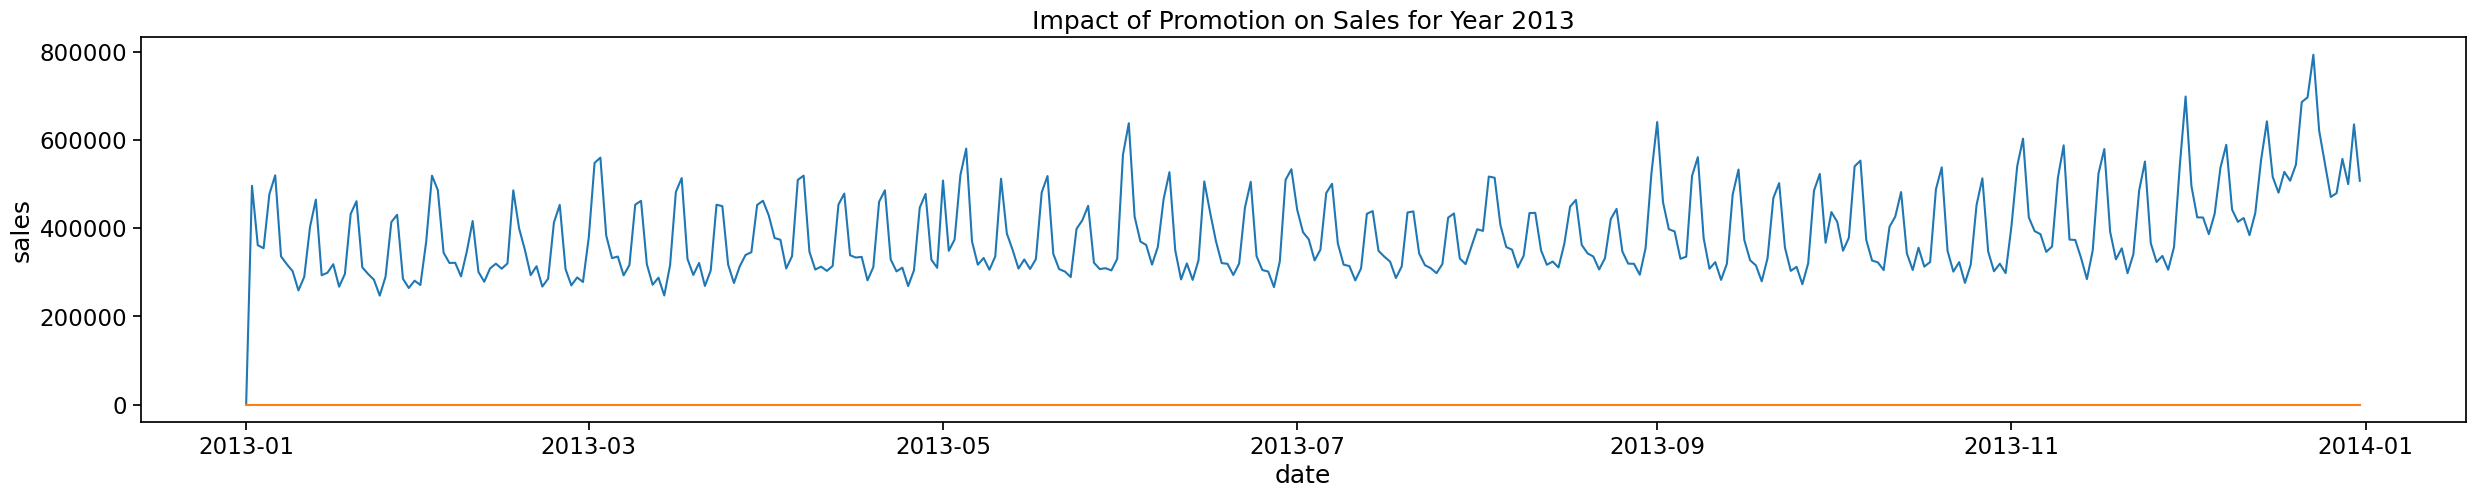

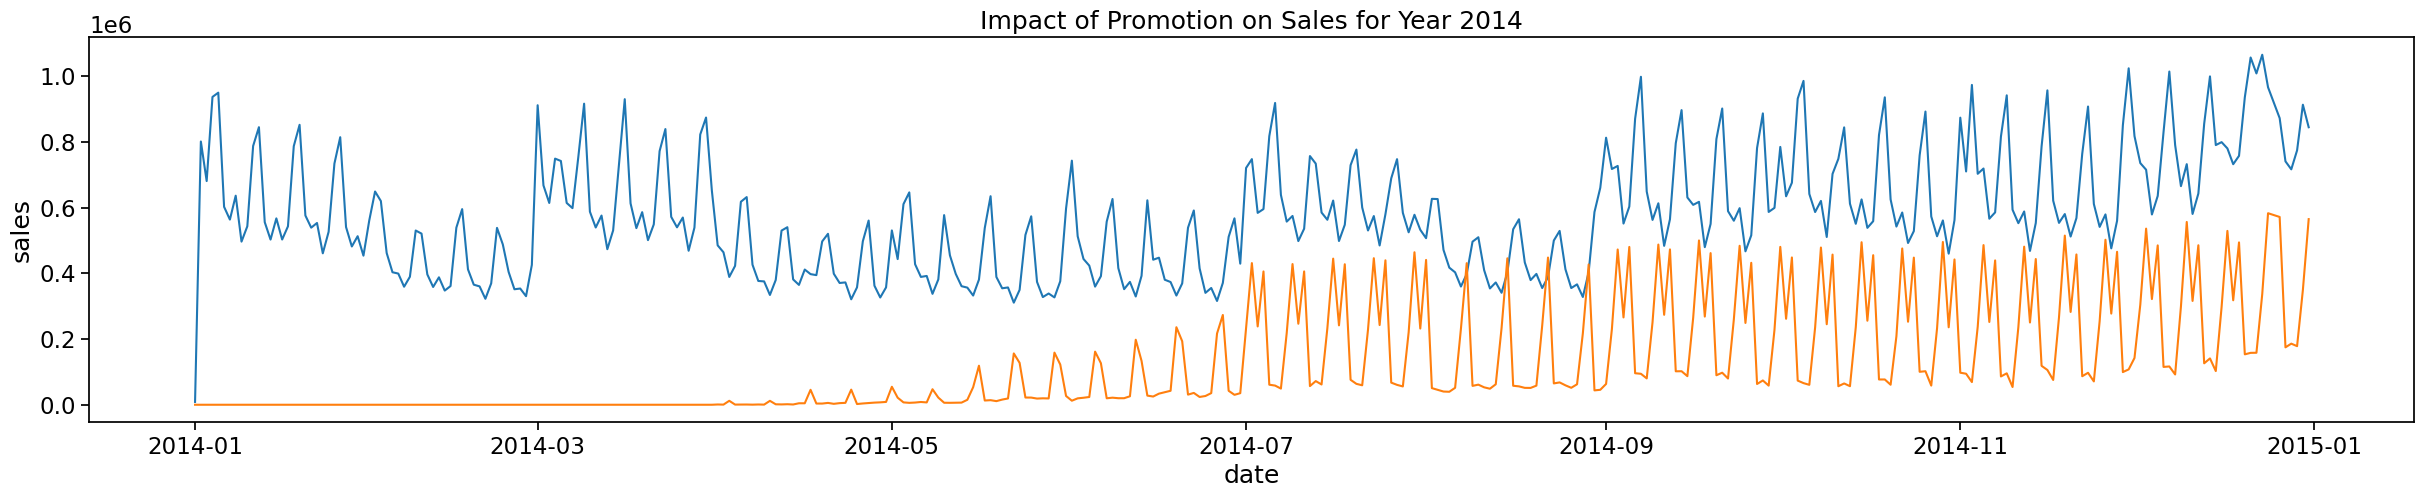

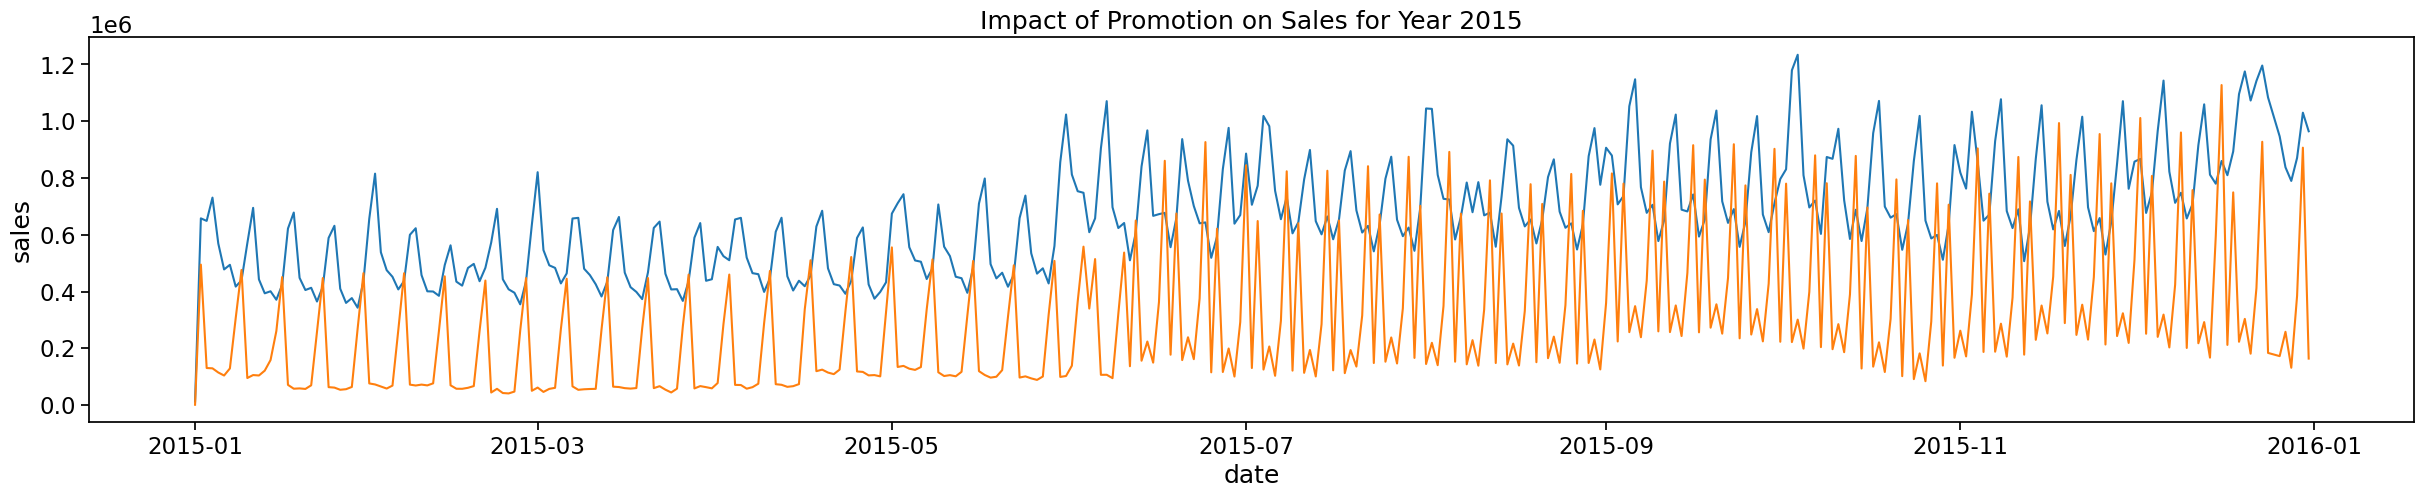

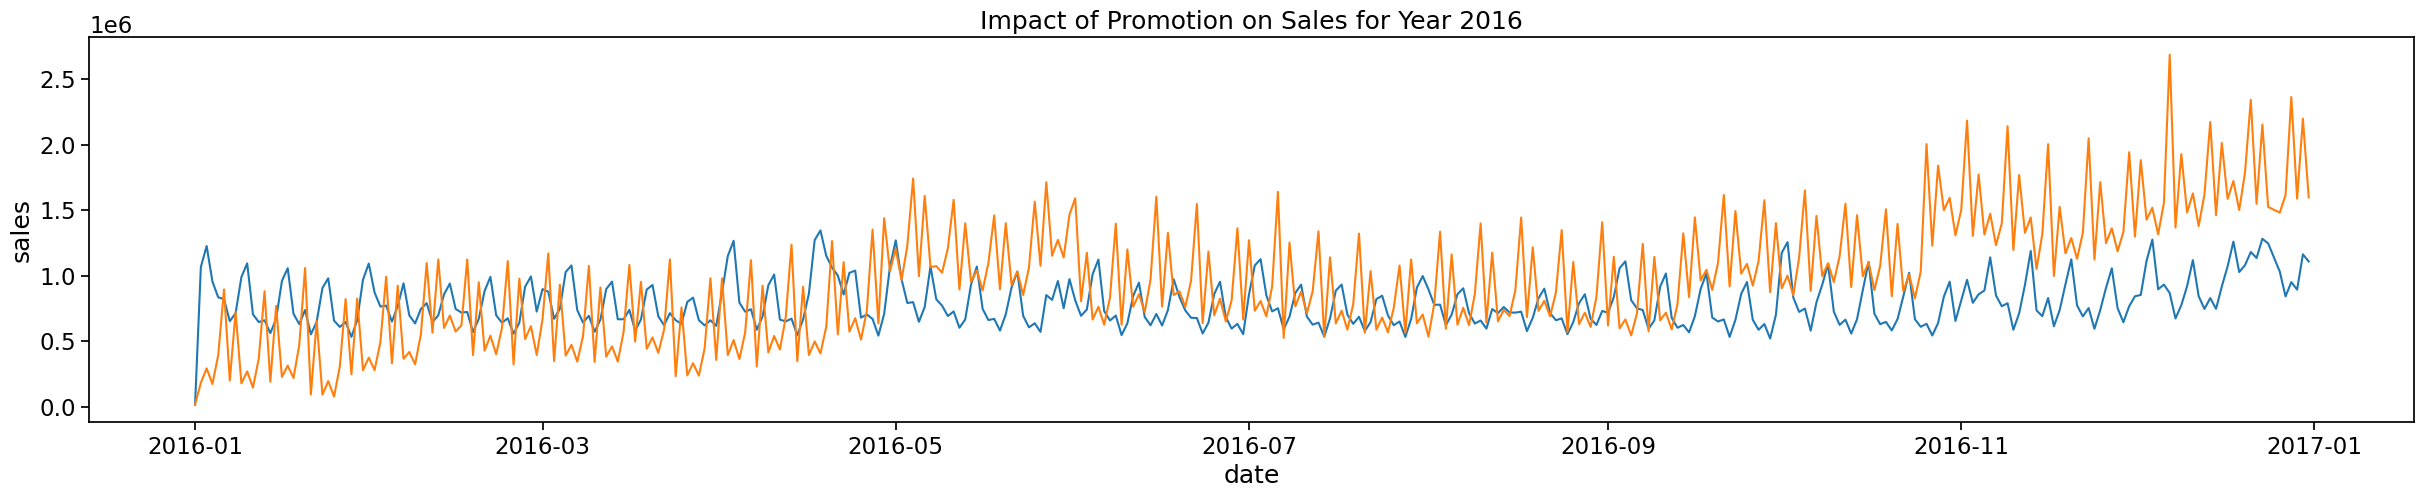

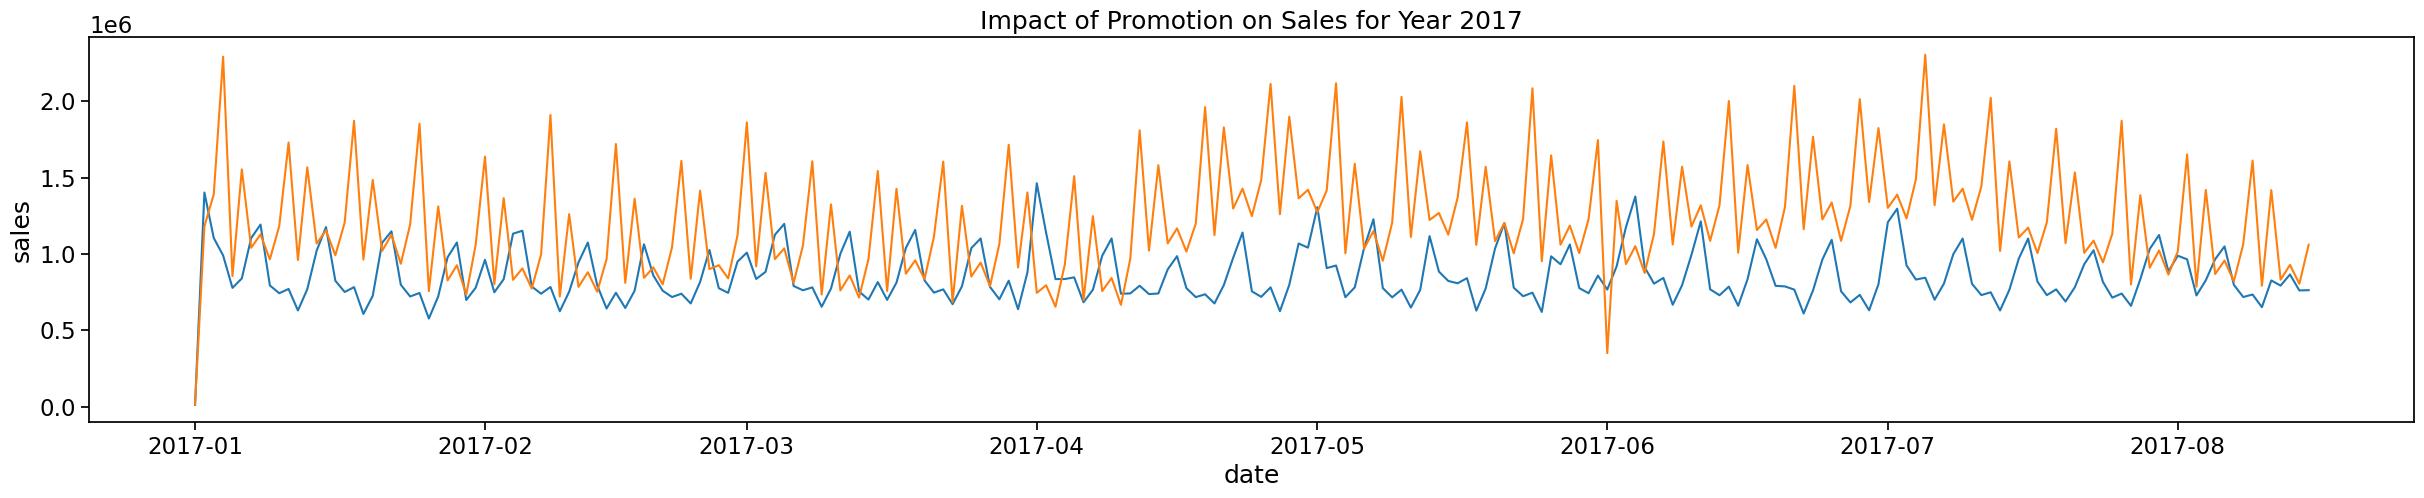

In [118]:
# Ploting impact of holidays on sales pover time
for year in train_merged.date.dt.year.unique():
    plt.figure(figsize=(30,5))
    df_daily_sales = train_merged[train_merged.date.dt.year == year].groupby(['date'])['sales'].sum()
    df_onpromotion = train_merged[train_merged.date.dt.year == year].groupby(['date'])['onpromotion'].sum()
    sns.lineplot(x=df_daily_sales.index, y=df_daily_sales)
    sns.lineplot(x=df_onpromotion.index, y=df_onpromotion*100)
    plt.title(f"Impact of Promotion on Sales for Year {year}")
    plt.show()

* We can clearly see that **onpromotion** has a positive effect on **sales**.

## 3. Data Cleaning

* Let's treat these missing values one by one.

In [119]:
# Let's fill missing values in transactions column by 0
train_merged.transactions.fillna(0, inplace=True)

In [120]:
# Let's fill the missing values in holiday_type, locale, locale_name, descriptions columns with 'Missing'
train_merged['description'].fillna('Missing', inplace=True)
train_merged['holiday_type'].fillna('Missing', inplace=True)
train_merged['locale'].fillna('Missing', inplace=True)
train_merged['locale_name'].fillna('Missing', inplace=True)

In [122]:
# Let's fill dcoilwtico with the average price of previous available month
train_merged['dcoilwtico'].fillna(method='ffill', inplace=True)

# Let's fill dcoilwtico with the average price of next available month, if previous month's price not present
train_merged['dcoilwtico'].fillna(method='bfill', inplace=True)

In [123]:
train_merged.isna().sum()

date            0
store_nbr       0
family          0
sales           0
onpromotion     0
city            0
state           0
product_type    0
cluster         0
transactions    0
holiday_type    0
locale          0
locale_name     0
description     0
dcoilwtico      0
is_holiday      0
dtype: int64

* There is no missing value in **train_merged** dataset, we can save this to a new file for further processing.

In [422]:
train_merged.to_csv('../../input/store_sales_time_series_forecasting/train_merged.csv', index=False)